This notebooks illustrates a pipeline for extracting overrepresented k-mers in set of sequences also called peaks.<br/>
Peaks are supposed to be produced by ChIP-seq experiments and they are examined in order to extract transcription factor binding sites (TFBS).<br/>
In the current form, the pipeline contains an initial procedure to extract variable-length words that are present in at least a given percentage of peaks. <br/>
The extracted words are then scored by means of different scoring procedures that are also compared each other.

# General notation

We denote with $S$ the input set of **peaks**, that are strings in the genomic **alphabet** $\Gamma = \{A,C,G,T\}$ .<br>
$S_i$ is th $i$-th peak, and they are ordered by their position in the reference genome.

We denote with $D(S)$ the complete set of substrings in $S$, of any length.<br>
Moreover, we denote with $D_K(S)$ the complete set of $k$-mers (words of a specific length $k$) that appeat at least once in $S$.

Given a word $w$ and a set of strings $S$, the **document listing problem** consists in enumerating the strings were $w$ occurrs at least once.<br>
We define $dl(w,S)$ the document listing of $w$ in $S$, also called the **support** of $w$ in $W$, namely the list of strings of $S$ where $w$ occurrs.<br>

We denote with $ml(w,S)$ the total number of occurrences of $w$ in S, and with $ml(w,S_i)$ the number of occurrences of $w$ within the specific string $S_i$.

In [3]:
iipeaks = 'ENCFF682EOV_best5000.fa'
iipeaks_nelsa = 'ENCFF682EOV_best5000.nelsa.csv'
ireextraction = 'ENCFF682EOV_best5000_random.fa'
ireextraction_nelsa = 'ENCFF682EOV_best5000_random.nelsa.csv'
imultiplere = 'ENCFF682EOV_best5000_random10.fa'
imultiplere_nelsa = 'ENCFF682EOV_best5000_random10.nelsa.csv'
ishuffling = 'ENCFF682EOV_best5000_shuff.fa'
ishuffling_nelsa = 'ENCFF682EOV_best5000_shuff.nelsa.csv'
imotif = 'MA0139.1.jaspar'

----

# A data structure to bring them all
In what follows, an enhaced suffix array (**ESA**) is used as main data structure on top of which algorithms are built.<br>
Wew remind that the ESA data structure is composed of the suffix arry $SA$ and the longest common prefix array $LCP$.<br>
Teh ESA structure is built for the set of sequences $S$, thus it represents all the suffixes of the strings in $S$.<br>
Teh structure is built on the concatenation of the strings in $S$ that is in the form $\mathbb{S} = S_1\$S_2\$\dots S_i\$S_{i+1}\$\dots \$S_n\$$.<br>

The followiing source code describes as a set of input sequences in FASTA format are read and concatenated into a global string.

In [4]:
def read_global_sequence(ifile, first_n=None):
    """
    Read a set of sequences in FASTA format and concatenat them into a global squences.
    Returns:
        - the original list of strings
        - a dict which maps sequence names (defined by the comment rows in the FASTA file) to their ID (defined by the order in which they are readed, starting from 0)
        - the global sequence ibtained by concatenation
    """
    gs = ''
    iline = 0
    seqname = ''
    seqname2id = dict()
    ipeaks = list()
    for line in open(ifile, 'r'):
        if iline%2 == 0:
            seqname = line.strip()
            seqname2id[seqname] = iline/2
        else:
            s = line.strip().upper().replace('N','$') + '$'
            ipeaks.append( (s, seqname) )
            gs += s
        iline += 1
        if first_n!=None and iline/2==first_n:
            break
    return ipeaks, seqname2id, gs 

The ESA structure is enriched with two additional arrays:
<ul>
    <li>the <b>DL array</b>  which reports for each suffix the string in $S$ to which it belongs to</li>
    <li>the <b>NN array</b> that is used in case the input string contains ambiguous characters $N$. This array is used in order to discard k-mer which contains $N$ characters in an efficient way</li>
</ul>

The following source code defined the given data structure, also called **DNESA**, and an iterator that can be used for enumerating all the $k$-mers contained in it.

In [5]:
class DNESA:
    def __init__(self, _sa, _lcp, _nn, _dl, _gs):
        self.sa = _sa
        self.lcp = _lcp
        self.nn = _nn
        self.dl = _dl
        self.gs  = _gs
        
    def search(self, w):
        l = 0
        r = len(self.gs)-1
        #ll,lr,rl,rr,m,cq
        for i in range(len(w)):
            #print('i',i)
            
            """
            while (l<len(self.nn)) and (self.nn[l] < len(w)-i):
                l += 1
            if l>r or (self.gs[self.sa[l]+i] > w[i]):
                return None,None
            
            while (r>l) and ( self.nn[r]<len(w)-i ):
                r -= 1
            if r<l or (self.gs[ self.sa[r]+i]<w[i] ):
                return None,None
            
            #print('new lr',l,r)
            """
            
            ll = l
            lr = r
            while ll!=lr:
                m = ll + int( (lr-ll)/2 )
                if w[i] <= self.gs[self.sa[m]+i]:
                    lr = m
                else:
                    ll = m+1
            l = ll
            #print('l',l)
            if l>r or w[i]!=self.gs[self.sa[l]+i]:
                return None,None
            
            #print('new l',l)
            
            rl = l
            rr = r
            #print(rl,rr)
            while rl!=rr:
                m = rl + int( (rr-rl)/2 )
                #print(rl,rr,m)
                if (rr-rl)%2 != 0:
                    m += 1
                if w[i] < self.gs[self.sa[m]+i ]:
                    rr = m-1
                else:
                    rl = m
            r = rr
            if r>len(self.sa) or self.gs[self.sa[r]+i] !=w[i]:
                return None,None
        
        return l,r+1



class NESAIterator:
    __s = None
    __k = 0
    __sa = None
    __lcp = None
    __ns = None
    __i = 0
    __j = 0
    
    def __init__(self, s, k, sa , lcp, ns):
        self.__s = s
        self.__k = k
        self.__sa = sa
        self.__lcp = lcp
        self.__ns = ns

    def get_k(self):
        return self.__k
    
    def reset(self):
        self.__i = 0
        self.__j = 0
        
        
    def __iter__(self):
        return self
    def __next__(self):
        if self.__i < len(self.__s):
            self.__i = self.__j
            
            while (self.__i < len(self.__s)) and  ( (self.__sa[self.__i] > len(self.__s) - self.__k - 1) or (self.__ns[self.__i] < self.__k) ):
                self.__i += 1
            if self.__i == len(self.__s):
                raise StopIteration
            self.__j = self.__i+1
            while ( self.__j < len(self.__s) ) and (self.__lcp[self.__j] >= self.__k) and (self.__ns[self.__i] >= self.__k) :
                self.__j += 1
            ret = self.__s[ self.__sa[self.__i] : self.__sa[self.__i] + self.__k ]
            #self.__i = self.__j #!!!!!!
            return ret
        else:
            raise StopIteration
            
    def get_start(self):
        return self.__i
    
    def get_end(self):
        return self.__j
    
    def multiplicity(self):
        return self.__j - self.__i
    
    def positions(self):
        return self.__sa[self.__i : self.__j]

The following source code provides a procedure to build the DNESA structure starting from an input set of sequences in FASTA format.<br>
The structure is write into a CSV file. 

In [6]:
import pandas
def build_DNESA(i_sequences_file, o_dataframe_file, first_n=None):
    ifile = i_sequences_file
    print('reading sequences')
    iline = 0
    seqname = ''
    seqname2id = dict()
    ipeaks = list()
    for line in open(ifile, 'r'):
        if iline%2 == 0:
            seqname = line.strip()
            seqname2id[seqname] = iline/2
        else:
            ipeaks.append( (line.strip().upper().replace('N','$') + '$', seqname) )
        iline += 1
        if first_n!=None and iline/2==first_n:
            break
            
    print('making global sequence')
    global_sequence = ''
    suffixes = list()
    for i in range(len(ipeaks)):
        peak = ipeaks[i][0]
        seqname = ipeaks[i][1]

        for p in range(len(peak)):
            suffixes.append( (len(global_sequence) + p, i) )
        global_sequence += peak

    print('seqname2id', len(seqname2id))
    print('global_sequence', len(global_sequence))
    print('suffixes', len(suffixes))
    
    print('ordering suffixes')
    def compare_suffixes(t1, t2):
        #print('comparing',t1,t2)
        i = t1[0]
        j = t2[0]
        l = len(global_sequence)
        k = 0
        while (i+k<l and j+k<l and global_sequence[i+k]==global_sequence[j+k]):
            k += 1
        if i+k==l:
            return -1
        elif j+k==l:
            return 1
        else:
            #print('@', ord(global_sequence[i+k]) - ord(global_sequence[j+k]))
            return ord(global_sequence[i+k]) - ord(global_sequence[j+k])

    from functools import cmp_to_key
    suffixes = sorted(suffixes, key=cmp_to_key(compare_suffixes) )

    sa = [ i[0] for i in suffixes]
    dl = [ i[1] for i in suffixes]

    for i in range(10):
        print(suffixes[i], global_sequence[suffixes[i][0]: suffixes[i][0]+30 ])
      
    print('creating LCP array')
    
   
    length = len(global_sequence)
    rank = [0 for i in range(length)]
    for i in range(length):
        rank[ sa[i] ] = i
    lcp = [0 for i in range(length)]
    h = 0
    for i in range(length):
        k = rank[i]
        if k==0:
            lcp[k] = -1
        else:
            j = sa[k-1]
            while (i+h<length) and (j+h<length) and (global_sequence[i+h] == global_sequence[j+h] ):
                h += 1
            lcp[k] = h
        if h>0:
            h -= 1
    
    print('creating NN array')
    length = len(sa)
    nn = [0 for i in range(length)]
    pn = length
    for i in range(length-1, -1, -1):
        if global_sequence[i]=='N' or global_sequence[i]=='$':
            nn[i] = 0
            pn = i
        else:
            nn[i] = pn -i
    fn = [0 for i in range(length)]
    for i in range(length):
        fn[i] = nn[sa[i]]
    nn = fn
    
    i = 0
    while global_sequence[sa[i]] == '$':
        i += 1

    #for i in range(i, i+10):
    #    print(global_sequence[suffixes[i][0]: suffixes[i][0]+30 ], global_sequence[sa[i]: sa[i]+30 ], sa[i], lcp[i], nn[i], dl[i])
        
    print('saving  dataframe to csv', o_dataframe_file)
    import pandas
    df = pandas.DataFrame()
    df['sa'] = sa
    df['lcp'] = lcp
    df['nn'] = nn
    df['dl'] = dl
    df.to_csv(o_dataframe_file)

This is an example of how to build a DNESA structure, save it and finally reload it into memory.<br>
Pandas DataFrame columns are converted into lists in order to increase the efficiency when using them.

In [4]:
# building and writing
build_DNESA(iipeaks, iipeaks_nelsa)

# reading
epeaks, es2n, egs = read_global_sequence(iipeaks)
edf = pandas.read_csv(iipeaks_nelsa)
print(len(epeaks), len(es2n), len(egs))
e_dnesa = DNESA(list(edf.sa), list(edf.lcp), list(edf.nn), list(edf.dl), egs)

reading sequences
making global sequence
seqname2id 5000
global_sequence 2416122
suffixes 2416122
ordering suffixes
(2416121, 4999) $
(896472, 1886) $AAAAAAAAAAAAAAAAAAGTAGCCTCAAC
(2044911, 4215) $AAAAAAAAAACAAACCTGTGCTTCCTACC
(1319540, 2643) $AAAAAAAAACACCCTCAAATTTCCCAACC
(1699795, 3306) $AAAAAAAAAGAGTTTAAAGCTTCCATCAT
(2211578, 4637) $AAAAAAAAAGGGAGAAATGTCTAATCATC
(1058183, 2195) $AAAAAAAACCTCCCTACAAAGTCAGCCCG
(1775994, 3439) $AAAAAAAAGGCCCACTTCTCAGATGGGCT
(1935813, 3897) $AAAAAAATAAAAAGAACCAATGAGAGTAG
(493687, 826) $AAAAAAATCAAGCCTGGCGTTTAACTTCA
creating LCP array
creating NN array
saving  dataframe to csv ENCFF682EOV_best5000.nelsa.csv
5000 5000 2416122


----

# Plotting procedures

This section simply report the plotting procedure used to make scatter plots of out data.

In [6]:
%matplotlib inline
#%matplotlib ipympl

import matplotlib.pyplot as plt


def plot_2d_scatter(df, col1, col2, plotsize=(5,5), up_hist_logscale=False):
    import matplotlib.pyplot as plt

    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.001
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.2]
    rect_histy = [left + width + spacing, bottom, 0.2, height]

    x = df[col1]
    y = df[col2]

    plt.figure(figsize=plotsize)
    ax_scatter = plt.axes(rect_scatter)
    ax_scatter.tick_params(direction='in', top=True, right=True)
    plt.xlabel(col1)
    plt.ylabel(col2)
    ax_histx = plt.axes(rect_histx)
    ax_histx.tick_params(direction='in', labelbottom=False)
    if up_hist_logscale:
        ax_histx.set_yscale('log')
    ax_histy = plt.axes(rect_histy)
    ax_histy.tick_params(direction='in', labelleft=False, labelbottom=False, labeltop=False)

    ax_scatter.scatter(x, y, marker='x')
    ax_histx.margins(x=0,y=0.1, tight=True)
    ax_histx.hist(x, bins=20)
    #ax_histx.margins(0)
    ax_histx.margins(x=0,y=0.1, tight=True)
    ax_histy.hist(y, orientation='horizontal', bins=20)
    ax_histy.margins(x=0.1,y=0, tight=True)
    #ax_histy.set_xticks([])
    plt.show()
    
    
    
def plot_2d_scatter_colors(df, col1, col2, col_colors, plotsize=(5,5), up_hist_logscale=False):
    import matplotlib.pyplot as plt
    x = df[col1]
    y = df[col2]
    plt.figure(figsize=plotsize)
    plt.scatter(x, y, marker='x', c=df[col_colors], cmap='viridis')
    plt.xlabel(col1)
    plt.ylabel(col2)
    cbar = plt.colorbar()
    cbar.set_label(col_colors)
    plt.show()
    
    
def plot_3d_scatter(df, col1, col2, col3, col_colors, plotsize=(10,10)):
    
    from matplotlib import pyplot
    from mpl_toolkits.mplot3d import Axes3D
    fig = pyplot.figure( figsize=plotsize)
    ax = Axes3D(fig)
    ax.set_xlabel(col1)
    ax.set_ylabel(col2)
    ax.set_zlabel(col3)

    ax.scatter(df[col1], df[col2], df[col3], c=df[col_colors])
    pyplot.show()
    


----

# k-mer score over PWM matrices (score and norm_score)

This section describes a procedure to calculate a score for a given k-mer over a PWM matrix of length $l$, when $ k \leq l$.<br>
Given an alphabet $\Sigma = \{ A,C,G,T \}$, a Position weight matrix (PWM) $M$ of length $|M|$ is a function $ f : \Sigma \times |M| \mapsto \mathbb{N} $.<br>
Thus, if we think about the PWM as a matrix where rows are indexed by symbols in $\Sigma$, each column represent a given position of the bindsing site.<br>
Moreover, $M$ is built such that the sum over columns are ensured to be equalt. Thus, for every $1 \leq i \leq |M|$, $\sum_{a \in \Sigma} M[a][i] = x$, for a given value of $x$.

Given a $k$-mer $w$ having the same length of $M$, the score of $w$ is given by $s(w,M) = \sum_{1 \leq i \leq |M|}M[ w[i] ][i]$, being $w[i]$ the $i$-th character of $w$.<br>
This score can be normalized by taking into account the maximum possbile score that can be obtained in the PWM.

If the length of the k-mer is less than the length of the PWM, then we are interested in finding the position $i$ where a maximum score for the k-mer can be obtained.<br>
Thus, we want to find the position $i$ which maximizes the score $s(w,M,i) = \sum_{i \leq j \leq i+|w|}M[ w[j-i] ][i]$, for $1 \leq i \leq |M| - |w|$.<br>
Therefore, for a k-mer $w$, such that $|w|\leq|M|$, $s(w,M) = max_{s(w,M,i)}\{ $ for $ 1 \leq i \leq |M| - |w| \}$.<br>
Moreover, this score can be normalized by taking into account the maximum score that can be obtained in the PWM by scanning for a unspecified word of length $|w|$, that is $ max_{s(t,M,i)}\{$ for $ t \in \Sigma^{|w|} $, for $ 1 \leq i \leq |M| - |w| \}$.


In [7]:
import re
def read_jaspar(ifile):
    """
    read a PWM matrix in jaspar format
    """
    motif = dict()
    for line in open(ifile,'r'):
        if line[0]!='>':
            line = line.strip()
            c = line[:line.index('[')].strip()
            motif[c] = list()
            s = re.split('\s+', line.strip())
            for i in range(2, len(s)-1):
                motif[c].append( int(s[i]) )
    return motif

def get_full_motif_score(pwm, word):
    """
    get the unnormalized score over a PWM matrix M for a word w wuch that |M| = |w|
    """
    score = 0.0
    for i in range(len(word)):
        score += pwm[word[i]][i]
    return score

def get_normalized_motif_score(m, w):
    """
    get the uormalized score over a PWM matrix M for a word w wuch that |M| >= |w|
    """
    lm = len(m[next(iter(m.keys()))])
    max_score = 0.0
    w_score = 0.0
    t =  [ max( [ m[k][i] for k in m.keys() ] ) for i in range(lm) ] 
    for i in range(lm-len(w)+1):
        ms = sum( t[i:i+len(w)] )
        if ms > max_score:
            max_score = ms
        ws = 0.0
        for j in range(len(w)):
            ws += m[w[j]][i+j]
        if w_score < ws:
            w_score = ws
    return w_score/max_score, w_score, max_score


# Some statistics regarding an already known PWM of CTCF

In what follows we try to understand how the k-mers generated via an already built PWM for the binding sites of CTCF match in a given set of sequences.<br>
In particular, we study the diffusion (suppport) of k-mers within the set of sequences in relation to the score that each k-mer gets in the PWM. 

In [115]:
import pandas

epeaks, es2n, egs = read_global_sequence(iipeaks)
edf = pandas.read_csv(iipeaks_nelsa)
print(len(epeaks), len(es2n), len(egs))
e_dnesa = DNESA(list(edf.sa), list(edf.lcp), list(edf.nn), list(edf.dl), egs)

ctcf = read_jaspar(imotif)

5000 5000 2416122


In [8]:
import pandas

k = len(ctcf['A'])
print('k',k)
it = NESAIterator( egs, k, list(edf.sa) , list(edf.lcp), list(edf.nn))
dl = list(edf.dl)

words = list()
scores = list()
dls = list()
mults = list()

for kmer in it:
    #print(kmer, it.multiplicity(), it.positions())
    #print(it.multiplicity(), it.positions())
    #print(kmer, it.multiplicity())
    words.append(kmer)
    mults.append( it.multiplicity())
    scores.append( get_full_motif_score(ctcf, kmer)  )
    dls.append( len(  set(  dl[ it.get_start() : it.get_end() ]  ) ) )
    
epwmstats = pandas.DataFrame()
epwmstats['word'] = words
epwmstats['score'] = scores
epwmstats['dl'] = dls
epwmstats['mult'] = mults
epwmstats.sort_values('score', ascending=False, inplace=True)


display(epwmstats)
print('max dl value', max(epwmstats['dl']))

k 19


,word,score,dl,mult
2058160,TGGCCACCAGGGGGCGCAA,11460.0,1,1
2058171,TGGCCACCAGGTGGCGCTG,11440.0,1,1
1786179,TAGCCACTAGGGGGCGCTA,11383.0,1,1
2058546,TGGCCAGCAGGTGGCGCTA,11382.0,1,1
2058161,TGGCCACCAGGTGGCACCA,11367.0,2,2
...,...,...,...,...
1435839,GCTTTCAGTATCCAGTTGT,785.0,1,1
1423067,GCTGGCTGCCCATTGCTGT,782.0,1,1
1361529,GCCGTCTGTCCACCGCTGC,757.0,1,1
1369457,GCCTGGAACTCCTCGCTGT,750.0,1,1


max dl value 48


In [9]:
epwmstats.to_csv('kmers-stats_ENCFF682EOV_best5000.csv')

In [10]:
import statistics
print(statistics.mean(epwmstats[ epwmstats.dl > 1]['dl']))

print(epwmstats.groupby('dl').size())

print(epwmstats.groupby(['dl']).agg(['mean']))

print(max(epwmstats.dl), len(set(edf.dl)))

3.097417840375587
dl
1     2285997
2        6974
3        1401
4         622
5         348
6         220
7         144
8         126
9          88
10         59
11         27
12         31
13         31
14         14
15          8
16         11
17         13
18         12
19          7
20          9
21         11
22          2
23          4
24          5
25          7
26          7
27          5
28          6
29          3
30          2
31          4
32          2
33          4
34          2
35          4
36          3
38          2
40          3
41          1
42          1
48          1
dtype: int64
          score        mult
           mean        mean
dl                         
1   4336.570581    1.000803
2   4416.485804    2.024806
3   4342.505353    3.077088
4   4245.381029    4.162379
5   4335.221264    5.405172
6   4344.450000    6.077273
7   4464.000000    7.319444
8   4381.611111    8.841270
9   4614.295455    9.011364
10  4272.271186   10.881356
11  4612.148148   11.000000


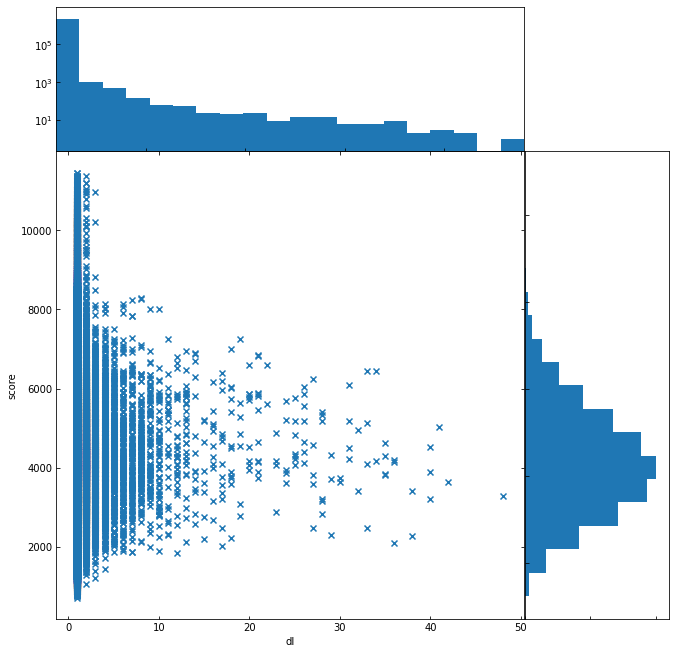

In [11]:
plot_2d_scatter(epwmstats, 'dl', 'score', plotsize=(10,10), up_hist_logscale=True)

k 4


,word,score,dl,mult
81,CCAC,1.000000,4367,13277
166,GGCG,0.976471,2679,8786
169,GGGC,0.975462,4111,15370
148,GCCA,0.973445,4420,13301
170,GGGG,0.962353,3829,15980
...,...,...,...,...
195,TAAT,0.399664,3314,8119
207,TATT,0.398992,3510,9991
247,TTCT,0.391261,4444,15138
223,TCTT,0.349916,4229,12687


max dl value 4651


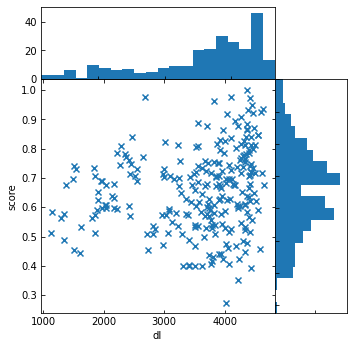

In [12]:
import pandas

k = 4
print('k',k)
it = NESAIterator( egs, k, list(edf.sa) , list(edf.lcp), list(edf.nn))
dl = list(edf.dl)

words = list()
scores = list()
dls = list()
mults = list()

for kmer in it:
    #print(kmer, it.multiplicity(), it.positions())
    #print(it.multiplicity(), it.positions())
    #print(kmer, it.multiplicity())
    words.append(kmer)
    mults.append( it.multiplicity())
    scores.append( get_normalized_motif_score(ctcf, kmer)[0]  )
    dls.append( len(  set(  dl[ it.get_start() : it.get_end() ]  ) ) )
    
epwmstats = pandas.DataFrame()
epwmstats['word'] = words
epwmstats['score'] = scores
epwmstats['dl'] = dls
epwmstats['mult'] = mults
epwmstats.sort_values('score', ascending=False, inplace=True)


display(epwmstats)
print('max dl value', max(epwmstats['dl']))

plot_2d_scatter(epwmstats, 'dl', 'score')

----

# Maximal words by a PWM score threshold

In this section we investigate the extension of 1-mers up to maximal words such that a minimum value of PWM score is maintained.<br> 
1-mers have a normalized PWM score equal to 1, we extend them until the PWM score is greater than  given threshold. A word is considred maximal if it passes the threshold but no its extension do it.

In [27]:
def extend_maximal_pwm(pwm, w, score_thr, extracted):
    if len(w) < len(pwm['A'])-1:
        atleastone = False
        for x in ['A','C','G','T']:
            if get_normalized_motif_score(pwm, w+x)[0] >= score_thr:
                atleastone = True
                extend_maximal_pwm(pwm, w+x, score_thr, extracted)
        if not atleastone:
             extracted.append( (w,get_normalized_motif_score(pwm, w)[0]) )
    else:
        extracted.append( (w,get_normalized_motif_score(pwm, w)[0]) )

In [32]:
pwm = read_jaspar(imotif)
print(pwm)

maximal_pwm_words = list()
pwm_thr = 0.9
extend_maximal_pwm(pwm, '', pwm_thr, maximal_pwm_words)

epeaks, es2n, egs = read_global_sequence(iipeaks)
edf = pandas.read_csv(iipeaks_nelsa)
print(len(epeaks), len(es2n), len(egs))
e_dnesa = DNESA(list(edf.sa), list(edf.lcp), list(edf.nn), list(edf.dl), egs)


for w in maximal_pwm_words:
    rs, re = e_dnesa.search(w[0])
    dl = 0
    if rs:
        dl = len(set( e_dnesa.lcp[rs:re] ))
    print(w[0],w[1], dl)

{'A': [87, 167, 281, 56, 8, 744, 40, 107, 851, 5, 333, 54, 12, 56, 104, 372, 82, 117, 402], 'C': [291, 145, 49, 800, 903, 13, 528, 433, 11, 0, 3, 12, 0, 8, 733, 13, 482, 322, 181], 'G': [76, 414, 449, 21, 0, 65, 334, 48, 32, 903, 566, 504, 890, 775, 5, 507, 307, 73, 266], 'T': [459, 187, 134, 36, 2, 91, 11, 324, 18, 3, 9, 341, 8, 71, 67, 17, 37, 396, 59]}
5000 5000 2416122
AGGGGGCACT 0.90873350182533 5
AGGGGGCAG 0.9334071496361911 11
AGGGGGCCC 0.9043024359379943 7
AGGGGGCGA 0.9191711483707687 8
AGGGGGCGCC 0.9172985116540298 9
AGGGGGCGCT 0.9276888514462229 8
AGGGGGCGGT 0.9031171019376579 4
AGGGGGCGT 0.9120531477380576 7
AGGGGGCTC 0.9049351471053464 6
CA 0.9389965792474344 80
CCACCAGAGGGAGCCA 0.9045029574508682 1
CCACCAGAGGGAGCTA 0.9115626788780767 0
CCACCAGAGGGCAACA 0.9134707116962412 0
CCACCAGAGGGCAACG 0.9004960885327228 0
CCACCAGAGGGCAATA 0.9205304331234497 0
CCACCAGAGGGCAATG 0.9075558099599313 0
CCACCAGAGGGCACAA 0.9320740316733448 0
CCACCAGAGGGCACAC 0.9109902690326274 1
CCACCAGAGGGCA

----

# Two background models

In order to assign a score to a k-mer that has been extracted by a given procedure, we can take into account the divergenge from the real case to a *random* one, also called background model.<br>
Here two different background models.

## Nucleotide shuffling procedure
The first one is computed by randomly shuffling the nucleotides in each sequence $S_i$, up to a given percentage. This model ensures that the 1-mer content of input sequences are preserved, however it may disrupt the k-mer composition for $k>2$. In fact, it is possible that, if sequences $S_i$ belong to a genome $G$, that this procedure may produce k-mers that do not belong to $G$. On the contrary, a pro of this method is that it try to preserve the context form which the sequences has been extracted.

In [13]:
import math
import random

random.seed(0)

iseqs = iipeaks
oseqs = ishuffling

shuff_perc = 0.2

def shuffle_seq(s):
    s = [ c for c in s.upper()]
    positions = [ i for i in range(len(s)-1) if s[i]!='N' ]
    for n in range( math.ceil(len(positions)*shuff_perc) ):
        i = random.randrange(0, len(positions) )
        j = random.randrange(0, len(positions) )
        t = s[i]
        s[i] = s[j]
        s[j] = t
    return ''.join(s)

with open(oseqs,'w') as off:
    iline = 0
    for line in open(iseqs,'r'):
        if iline%2==0:
            off.write(line)
        else:
            s = shuffle_seq(line)
            off.write(s)
            if iline < 20:
                print(line[:100], s[:100])
        iline +=1
    
print(iline)

CCCGGTTGTGCCATCAACAGGACATTATACACTGCACAGCAACACCACTGCCACCACCTGCCATGGGCTCTCCCTGGCCAGGTGGGCAGCCCTAACAGCG TCCGGTTGTGCCTTCAACAGGATCTTATACACTGCACGGCCGCACCATTGCAACCACCTTCCTGCGGCTCCACGTTGCCATGCGGGCAGCCTTGACATCG
CCTCCTGTCTACTTGGAGGAAAGGGACCGGGACACACAGAGGCGCAGGGGGCTGAACCCTCGGTTCCAGCCCCGATAACTCATCCGGAGTCACGCGGTTC ACGACTGTCGACTTTTAGGGCACGGACCAGGACACATACAAGCACAGGGCGCTGAACCCTCGCGTTCGGCCCGGATAAGTCATGCAGAGTCACGCAGTTC
CAGGGGCCCTATCAGTGCTCATGTGGTCACGTAGACACACTTCAACTTGAGCTTCAGGTGGGATGCTTCCCTATAAGCAGTGAACGCGAAAAGCCTTGGC TCGTGGCGTTCTCAGTGCTCTTTTGGTACCATAGACGCAGTCCAACTGAAGCTTCATGTGGAATACTTCCCTTTGAGCAATGGTCGTTAAAAGACATGGC
CAAACTTTAATGATCCTAGAAAGCTGGTTTGAATCAGTTTTTACAGGGTTGTTTTGGATTTAAAATAACTAAAACTTGAGAGCTGGGAGAAATTTTATTT CAAACTGTACGGATCCAAGAAAGCTGATTTGAATGAGTTTCTAAATGGTTTTTATCGAGTTGAAACAACGAAAAATTGGGAGAAGGAGAAAATTTTATTT
GTAAAATGTATTCACAACTCAGGTATACAGTGCTTTCTGATTTAAATGGCAGGAAAAAAATTTTCAGACACTGAAAAGATTCGGTATCTCCCACCCCCTA GAAAAATGTTTTGACGAGTCACTTATATAGTGCTTCCTGGTAAATATGGCAGCAAAAAAGGTCACATAAACAGAAAAGTTCTGGTATCTCC

In [15]:
build_DNESA(ishuffling, ishuffling_nelsa)

reading sequences
making global sequence
seqname2id 5000
global_sequence 2416122
suffixes 2416122
ordering suffixes
(2416121, 4999) $
(2211578, 4637) $AAAAAAAACGGCAGATAGGTCTAATCATC
(1462014, 2888) $AAAAAAAGAAATTGGCCGGCACCTGTAAT
(2114482, 4419) $AAAAAAAGAGAACTGCGCTGGACCGGCTC
(1935813, 3897) $AAAAAAATTTCGAGAGCCATTGAGAGTAG
(2172885, 4567) $AAAAAAGTTCTATGGGGATCACCCTGCAC
(2116919, 4427) $AAAAAATTATGTAGCAATTTGCAAAATTT
(1259216, 2541) $AAAAACACTAATAGCTGTGCGGCCCTGGA
(943470, 1999) $AAAAACAGTGGCGATTCTGCTCAGTTTCT
(314234, 522) $AAAAACCCCTAGAGCTGGGCCTGGCCCTT
creating LCP array
creating NN array
saving  dataframe to csv ENCFF682EOV_best5000_shuff.nelsa.csv


## Sequence re-extraction procedure 
A second procedure randomly extracts sequences from a genome $G$ by preserving the length of the sequences extracted in position $i$. In this way, the new sequences are originated formt he genome $G$, thus it is ensured that every k-mers occuring in them is a *real* k-mer. On the contrary, no restriction is ensured regarding the context from which they are extracted.

This procedure is made by using the bed tools software.

In [16]:
build_DNESA(ireextraction, ireextraction_nelsa)

reading sequences
making global sequence
seqname2id 5000
global_sequence 2416122
suffixes 2416122
ordering suffixes
(2416121, 4999) $
(490754, 822) $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
(490755, 823) $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
(490756, 823) $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
(490757, 823) $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
(490758, 823) $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
(490759, 823) $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
(490760, 823) $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
(490761, 823) $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
(490762, 823) $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
creating LCP array
creating NN array
saving  dataframe to csv ENCFF682EOV_best5000_random.nelsa.csv


# A mutliple re-extraction precedure

We also evaluate a multiple re-extraction procedure such that multiple background peak sets are extracted and the presence of a given k-mer in a given sequence  is the result (the average) of its multiplcity in the corresponding multiple peaks.<br>
Thus, the background model is a set of sets of sequences, named $\mathbb(B) = \{ B^1, B^2, \dots, B^n \}$. Thus the multilpcity of a k-mer for the $i$-th peak is given by $ml(w, \mathbb{B}) = \frac{\sum_{1 \leq i \leq n}ml(w,B^i)}{n}$.<br>
However, this model can produce problems if we want to calculate the frequency of the kmer at the $i$-th peak.<br>
Thu we make an hypothesis that, instead of computing the average multiplcity, if we take into account backgorund sequences having lenth a factor ($>1$), then the multiplicity are comparable.

In [176]:
import wget
filename = wget.download('https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz')

In [187]:
import gzip
import statistics

hg38chrs = dict()
s = ''
sn = ''
for line in gzip.open('hg38.fa.gz', 'rt'):
    if line[0] == '>':
        if len(s) > 0:
            hg38chrs[sn] = s.upper()
        s = ''
        sn = line.strip().replace('>','')
    else:
        s += line.strip()
if len(s) > 0:
    hg38chrs[sn] = s.upper()  
        
print(len(hg38chrs))
print(sum([len(v) for v in hg38chrs.values()]))

455
3209286105


In [205]:
import random
random.seed(0)

with open(imultiplere, 'w') as off:
    utimes = 10
    #imultiplere
    iline = 0
    for line in open(iipeaks,'r'):
        if line[0] == '>':
            gchr = line.strip().split(':')[0].replace('>','')
            p1 = int(line.strip().split(':')[1].split('-')[0])
            p2 = int(line.strip().split(':')[1].split('-')[1])
            l = p2-p1
            #print(gchr, p1, p2, p2-p1)
            
            ps = list()
            s = ''
            for n in range(utimes):
                si = 'N'
                while 'N' in si:
                    p = random.randint(0, len(hg38chrs[gchr]) - l)
                    si = hg38chrs[gchr][p : p+l]
                s += si+'N'
                ps.append(p)
            #print(l,line.strip())
            #print(len(s), s[:100])
            
            off.write(line.strip()+':x10:'+'-'.join([str(s)for s in ps])+'\n')
            off.write(s)
            off.write('\n')

            #if iline > 10:
            #    break
            iline += 1
    print(iline)
        

5000


In [208]:
build_DNESA(imultiplere, imultiplere_nelsa)

reading sequences
making global sequence
seqname2id 5000
global_sequence 24166220
suffixes 24166220
ordering suffixes
(24166219, 4999) $
(24166218, 4999) $$
(6949694, 1315) $$AAAAAAAAAAAAAGCTCTTTATTTTTAA
(2675472, 443) $$AAAAAAAAGGACTAAATGGATTCACAGC
(10278332, 2143) $$AAAAAAAGGAAAAGGATATGACAACATT
(5771832, 983) $$AAAAAACAAGTGATAATCAGTCAGGGGA
(6165278, 1089) $$AAAAAACGCAAAAGCCAGCAGGCTGGCC
(16056206, 3137) $$AAAAAACTAAACCAAAACTGTAAGAGAT
(18091238, 3529) $$AAAAAAGTGCACCAAGTCATATTAGTCA
(18124326, 3537) $$AAAAAATTAAGTGATTAAAACTACAACA
creating LCP array
creating NN array
saving  dataframe to csv ENCFF682EOV_best5000_random10.nelsa.csv


----

# A ranking procedure for k-mers based on KL divergence terms (kl_rank and norm_kl_rank)

This section shows a methodology to rank k-mers, being all of the same length $k$, by taking into account their single contribution to the calculation of a Kullback-Leibler (KL) divergence form a real case, also called foreground, and a background model $B$.<br>
Given a word length $k$, the procedure takes into account the multiplicities of the k-mers occurring at least one in the foreground sequence set $S$.<br>
The KL divergence is calculated as $ \sum_{w \in D_k(S)}p(w,S) log \frac{p(w,S)}{p(w,B)} $, where p(w,S) is the frequency of $w$ in $S$, that is computed as $\frac{ml(w,S)}{ \sum_i{|S_i|-|w|+1}}$ if sequences in $S$ do not contains $N$ characters.<br>
For practical applicatios, it is possible that a k-mer does not occurr in the backgorund set $B$, in this case a very small value is assigned to it and it is ensured that $\sum_{w \in D_k(S)}p(w,B) = 1$.<br>
Givne a k-mer, its rank is caluclated by ordering the k-mers by their values such that  $kl\_rank(w,S,B) = p(w,S) log \frac{p(w,S)}{p(w,B)}$. In this way a k-mer that is over-represented in the foregound w.r.t the background set has a positive contribution, and k-mers that are under-represented have negative contributions.

In addition, the $kl\_rank$ values can be normalized to be values in $[0,1]$ by taking into account the minimum value $kl_min = min_{w \in D_k(S)} kl\_rank(w,S,B)$ and the maximum value $kl_max = max_{w \in D_k(S)} kl\_rank(w,S,B)$, such that $norm\_kl\_rank(w,S,B) = \frac{kl\_rank(w,S,B)  - kl\_min}{kl\_max - kl\_min} $

In [8]:
import math

def get_kl_scores(k, egs, edf, rgs, rdf):
    f_kmers = dict()

    it =  NESAIterator( egs, k, list(edf.sa) , list(edf.lcp), list(edf.nn))
    for kmer in it:
        f_kmers[kmer] = it.multiplicity()

    b_kmers = dict()

    it =  NESAIterator( rgs, k, list(rdf.sa) , list(rdf.lcp), list(rdf.nn))
    for kmer in it:
        b_kmers[kmer] = it.multiplicity()

    kmers = f_kmers.keys() | b_kmers.keys()

    for kmer in kmers:
        f_kmers[kmer] = f_kmers.get(kmer,0)+1
        b_kmers[kmer] = b_kmers.get(kmer,0)+1

    f_sum = sum(f_kmers.values())
    b_sum = sum(b_kmers.values())

    scores = dict()
    sorted_scores = list()
    for kmer in kmers:
        f_kmers[kmer] = f_kmers[kmer]/f_sum
        b_kmers[kmer] = b_kmers[kmer]/b_sum
        scores[kmer] = f_kmers[kmer] * math.log( f_kmers[kmer] / b_kmers[kmer] )
        sorted_scores.append((scores[kmer],kmer))
    sorted_scores = sorted(sorted_scores, reverse=True)
    
    min_score = min(scores.values())
    max_score = max(scores.values())
    
    norm_sorted_scores = list()
    for s in sorted_scores:
        norm_sorted_scores.append(  (  (s[0]-min_score)/(max_score - min_score), s[1] )  )
        
    return sorted_scores, norm_sorted_scores
    

----

# A DL-aware scoring procedure for k-mers of variable length (norm_kl_score)
This section shows a scoring procedure that can be used ot recognize statistically over-represented k-mers in a set of sequence, such that the computation of the score for a specific k-mer does not depend form the computaiton of the score of any other k-mer.<br>
In addiction, this procedure enables to take into account the contribution that each sequence in the input set $S$ has to the multiplicity of the k-mer.<br>
The only constraint is that $|S_i| = |B_i|$.<br>
Given a k-mer $w \in D_k(G)$, the score of $w$ is calculated by normalizing the divergence $KL(w,S,B) = \sum_i{ p(w,S_i) log \frac{p(w,S_i)}{p(w,B_i)} }$ for the maximum value of KL that the distribution $p(w,S_i)$ can reach.<br>
In order to estimate the maximum KL value for the distribution $p(w,S_i)$, we takes into account a reordering of the sequences $S_i$, referred to as $\widehat{S}$, such that $p(w,\widehat{S_i})\geq p(w,\widehat{S_{i+1}})$, and a reodering $\bar{S}$ such that $p(w,\bar{S_i})\leq p(w,\bar{S_{i+1}})$.<br>
It can be shown that the given score is not the maximum that the KL divergence can reach, when $p(w,S_i), p(w,B_i) \neq 0$, however, we can empirically show that it is a good upperbound to the KL value in practical applications.<br>
Finally, the score for a given k-mer $w$ is $norm\_kl\_score(w,S,B) = \frac{KL(w,S,B)}{KL(w,\widehat{S},\bar{S})}$.

In [9]:
def get_m_distr(dnesa, istart, iend):
    distr = dict()
    for i in range(istart, iend):
        distr[ dnesa.dl[i] ] = distr.get(dnesa.dl[i], 0)+1
    return distr

def m_dsitr_to_seq_freq(m_distr, seq_lengths, k):
    f_distr = dict()
    for s,v in m_distr.items():
        f_distr[s] = v/( seq_lengths[s]-k+1 )
    return f_distr

def make_prob_distr(idistr):
    odistr = dict()
    s = sum(idistr.values())
    for k,v in idistr.items():
        odistr[k] = v/s
    return odistr

def add_unzeros(idistr, max_k, miss_value=0.0000001):
    odistr = dict()
    for i in range(max_k):
        odistr[i] = idistr.get(i, miss_value)
    return odistr

def calculate_kl(d1,d2):
    kl = 0
    for k in d1.keys():
        kl += d1[k] * math.log(d1[k]/d2[k])
    return kl
        

def calculate_norm_kl(kmer, egs, e_dnesa, rgs, r_dnesa, seq_lengths, nof_peaks):
    es, ef = e_dnesa.search(kmer)
    rs, rf = r_dnesa.search(kmer)
    if es and rs:
        d1 = make_prob_distr( add_unzeros( m_dsitr_to_seq_freq( get_m_distr( e_dnesa, es, ef ), seq_lengths, len(kmer) ), nof_peaks) )
        d2 = make_prob_distr( add_unzeros( m_dsitr_to_seq_freq( get_m_distr( r_dnesa, rs, rf ), seq_lengths, len(kmer) ), nof_peaks) )

        dd = list()
        for k,v in d1.items():
            dd.append( (v,k) )
        dd = sorted( dd )
        d1m = dict()
        for i in range(len(dd)):
            d1m[ dd[i][1] ] = dd[ len(dd)-i-1 ][0]

        return calculate_kl(d1,d2) / calculate_kl(d1,d1m)
    return 0.0
    

----

# A comparision on fixed-length word sets using a nucleotide shuffling model

In this section we show a comparison between the two scoring procedures $kl\_rank$ and $norm\_kl\_score$ on sets of words of fixed (same) length $k$, by taking into account the nucleotide shuffling model.


In [118]:
epeaks, es2n, egs = read_global_sequence(iipeaks)
edf = pandas.read_csv(iipeaks_nelsa)
print(len(epeaks), len(es2n), len(egs))
e_dnesa = DNESA(list(edf.sa), list(edf.lcp), list(edf.nn), list(edf.dl), egs)

rpeaks, rs2n, rgs = read_global_sequence(ishuffling)
rdf = pandas.read_csv(ishuffling_nelsa)
print(len(rpeaks), len(rs2n), len(rgs))
r_dnesa = DNESA(list(rdf.sa), list(rdf.lcp), list(rdf.nn), list(rdf.dl), rgs)

5000 5000 2416122
5000 5000 2416122


In [119]:
ctcf = read_jaspar(imotif)

In addition a symmetric KL distance and a generalized Jaccard similarity calculated on top of DL vectors are taken into accont.

In [10]:
def calulcate_generalized_jaccard(d1, d2):
    nom = 0.0
    den = 0.0
    for k in (d1.keys()|d2.keys()):
        nom += max( d1.get(k,0), d2.get(k,0) )
        den += min( d1.get(k,0), d2.get(k,0) )
    if den > 0:
        return nom/den
    else:
        return 0

def calculate_symmetric_kl(d1, d2):
    return (calculate_kl(d1,d2)+calculate_kl(d2,d1))/2

In [121]:
k = 5

kl_rank, norm_kl_rank =  get_kl_scores(k, egs, e_dnesa, rgs, r_dnesa)
#print(kl_rank)

seq_lengths = dict()
for i in range(len(epeaks)):
    seq_lengths[i] = len(epeaks[i][0])
nof_peaks = len(epeaks)

mult = list()
dl = list()
norm_pwm_score = list()
norm_kl = list()
kl_to = list()
symmetric_kl = list()
jaccard = list()

for s in kl_rank:
    kmer = s[1]
    
    norm_pwm_score.append( get_normalized_motif_score(ctcf, kmer)[0] )
    norm_kl.append( calculate_norm_kl(kmer, egs, e_dnesa, rgs, r_dnesa, seq_lengths, nof_peaks ) )
    ks, ke = e_dnesa.search(kmer)
    if ks:
        rs, rf = r_dnesa.search(kmer)
        if rs:
            d1 = get_m_distr( e_dnesa, ks, ke )
            d2 = get_m_distr( r_dnesa, rs, rf )
            jaccard.append(calulcate_generalized_jaccard(d1,d2))
            
            d1 = make_prob_distr( add_unzeros( m_dsitr_to_seq_freq( get_m_distr( e_dnesa, ks, ke ), seq_lengths, len(kmer) ), nof_peaks) )
            d2 = make_prob_distr( add_unzeros( m_dsitr_to_seq_freq( get_m_distr( r_dnesa, rs, rf ), seq_lengths, len(kmer) ), nof_peaks) )
            kl_to.append( calculate_kl(d1,d2) )
            symmetric_kl.append( calculate_symmetric_kl(d1,d2) )
        else:
            symmetric_kl.append(0)
            jaccard.append(0)
        
        mult.append(ke-ks)
        dl.append( len(set(edf.dl[ks:ke])))
    else:
        mult.append(0)
        dl.append(0)
        symmetric_kl.append(0)
        jaccard.append(0)
        
import pandas
exp1_df = pandas.DataFrame()
exp1_df['kmer'] = [ s[1] for s in kl_rank ]
exp1_df['norm_pwm_score'] = norm_pwm_score
exp1_df['dl'] = dl
exp1_df['mult'] = mult
exp1_df['kl_rank'] = [ s[0] for s in kl_rank ]
exp1_df['norm_kl_rank'] = [ s[0] for s in norm_kl_rank ]
exp1_df['norm_kl_to'] = norm_kl
exp1_df['norm_kl_score'] = norm_kl
exp1_df['symmetric_kl'] = symmetric_kl
exp1_df['jaccard'] = jaccard

print('-'*40)
display(exp1_df)

exp1_df.to_csv('scores.best5000.shuffle.k'+str(k)+'.csv')

----------------------------------------


,kmer,norm_pwm_score,dl,mult,kl_rank,norm_kl_rank,norm_kl_to,norm_kl_score,symmetric_kl,jaccard
0,TTTTT,0.220248,2528,9017,0.001923,1.000000,0.208897,0.208897,2.244013,2.695519
1,AAAAA,0.471190,2443,8884,0.001847,0.966102,0.221523,0.221523,2.348745,2.743973
2,CTGGG,0.652666,3221,6647,0.001467,0.796482,0.362886,0.362886,2.534751,2.491245
3,CCTGG,0.659128,3224,6557,0.001418,0.775017,0.366005,0.366005,2.547677,2.500000
4,CCCAG,0.761982,3233,6592,0.001370,0.753269,0.364792,0.364792,2.500706,2.436629
...,...,...,...,...,...,...,...,...,...,...
1019,CCGGC,0.682553,1278,2403,-0.000284,0.015461,0.243887,0.243887,3.164956,2.548223
1020,GCACG,0.655627,808,964,-0.000291,0.012669,0.493650,0.493650,5.665957,4.731518
1021,TGCCG,0.667474,904,1147,-0.000300,0.008354,0.446515,0.446515,5.293447,4.184252
1022,CGGCG,0.785407,833,1847,-0.000302,0.007432,0.190995,0.190995,2.967650,2.619763


In [24]:
display(exp1_df)

,kmer,norm_pwm_score,dl,mult,kl_rank,norm_kl_rank,norm_kl_score,symmetric_kl,jaccard
0,TTTTT,0.220248,2528,9017,0.001923,1.000000,0.208897,2.244013,2.695519
1,AAAAA,0.471190,2443,8884,0.001847,0.966102,0.221523,2.348745,2.743973
2,CTGGG,0.652666,3221,6647,0.001467,0.796482,0.362886,2.534751,2.491245
3,CCTGG,0.659128,3224,6557,0.001418,0.775017,0.366005,2.547677,2.500000
4,CCCAG,0.761982,3233,6592,0.001370,0.753269,0.364792,2.500706,2.436629
...,...,...,...,...,...,...,...,...,...
1019,CCGGC,0.682553,1278,2403,-0.000284,0.015461,0.243887,3.164956,2.548223
1020,GCACG,0.655627,808,964,-0.000291,0.012669,0.493650,5.665957,4.731518
1021,TGCCG,0.667474,904,1147,-0.000300,0.008354,0.446515,5.293447,4.184252
1022,CGGCG,0.785407,833,1847,-0.000302,0.007432,0.190995,2.967650,2.619763


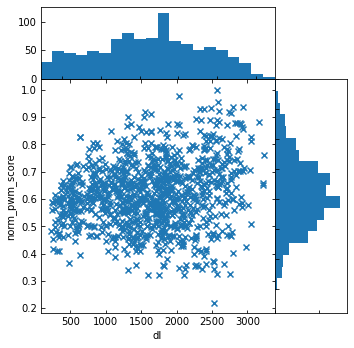

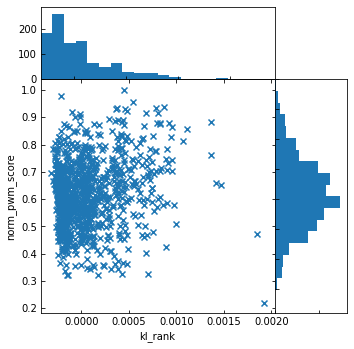

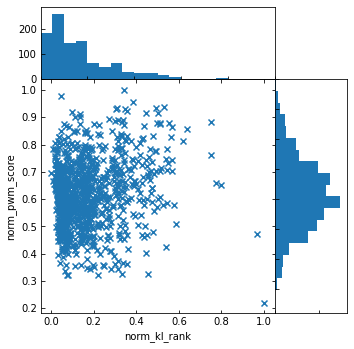

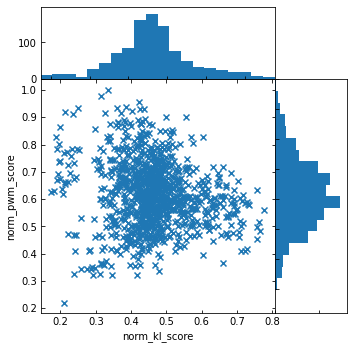

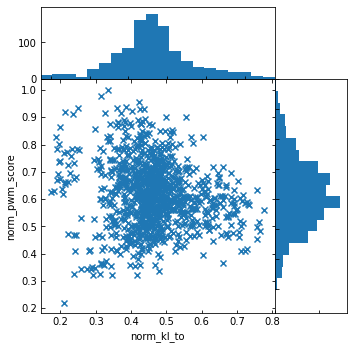

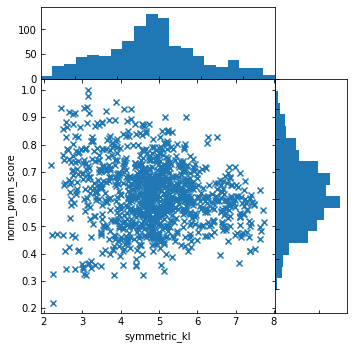

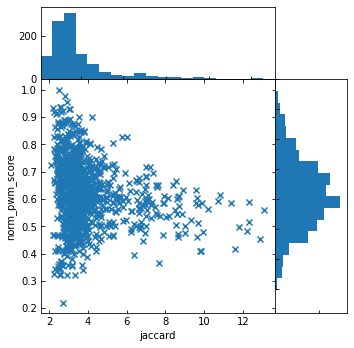

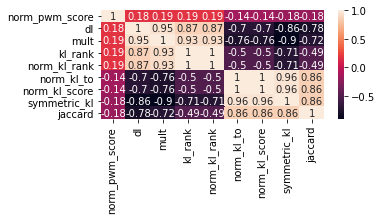

In [123]:
df = exp1_df

plot_2d_scatter(df, 'dl', 'norm_pwm_score')

plot_2d_scatter(df, 'kl_rank', 'norm_pwm_score')
plot_2d_scatter(df, 'norm_kl_rank', 'norm_pwm_score')
plot_2d_scatter(df, 'norm_kl_score', 'norm_pwm_score')
plot_2d_scatter(df, 'norm_kl_to', 'norm_pwm_score')
plot_2d_scatter(df, 'symmetric_kl', 'norm_pwm_score')
plot_2d_scatter(df, 'jaccard', 'norm_pwm_score')

import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
plt.figure(figsize=(5,2))
corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

----

# A comparision on fixed-length word sets using a sequence re-extraction model

In this section we show a comparison between the two scoring procedures $kl\_rank$ and $norm\_kl\_score$ on sets of words of fixed (same) length $k$, by taking into account the nucleotide shuffling model.


In [124]:
epeaks, es2n, egs = read_global_sequence(iipeaks)
edf = pandas.read_csv(iipeaks_nelsa)
print(len(epeaks), len(es2n), len(egs))
e_dnesa = DNESA(list(edf.sa), list(edf.lcp), list(edf.nn), list(edf.dl), egs)

rpeaks, rs2n, rgs = read_global_sequence(ireextraction)
rdf = pandas.read_csv(ireextraction)
print(len(rpeaks), len(rs2n), len(rgs))
r_dnesa = DNESA(list(rdf.sa), list(rdf.lcp), list(rdf.nn), list(rdf.dl), rgs)

5000 5000 2416122
5000 5000 2416122


In [27]:
ctcf = read_jaspar(imotif)

In addition a symmetric KL distance and a generalized Jaccard similarity calculated on top of DL vectors are taken into accont.

In [126]:
k = 4

kl_rank, norm_kl_rank =  get_kl_scores(k, egs, e_dnesa, rgs, r_dnesa)
#print(kl_rank)

seq_lengths = dict()
for i in range(len(epeaks)):
    seq_lengths[i] = len(epeaks[i][0])
nof_peaks = len(epeaks)

mult = list()
dl = list()
norm_pwm_score = list()
norm_kl = list()
kl_to = list()
symmetric_kl = list()
jaccard = list()

for s in kl_rank:
    kmer = s[1]
    
    norm_pwm_score.append( get_normalized_motif_score(ctcf, kmer)[0] )
    norm_kl.append( calculate_norm_kl(kmer, egs, e_dnesa, rgs, r_dnesa, seq_lengths, nof_peaks ) )
    ks, ke = e_dnesa.search(kmer)
    if ks:
        rs, rf = r_dnesa.search(kmer)
        if rs:
            d1 = get_m_distr( e_dnesa, ks, ke )
            d2 = get_m_distr( r_dnesa, rs, rf )
            jaccard.append(calulcate_generalized_jaccard(d1,d2))
            
            d1 = make_prob_distr( add_unzeros( m_dsitr_to_seq_freq( get_m_distr( e_dnesa, ks, ke ), seq_lengths, len(kmer) ), nof_peaks) )
            d2 = make_prob_distr( add_unzeros( m_dsitr_to_seq_freq( get_m_distr( r_dnesa, rs, rf ), seq_lengths, len(kmer) ), nof_peaks) )
            kl_to.append( calculate_kl(d1,d2) )
            symmetric_kl.append( calculate_symmetric_kl(d1,d2) )
        else:
            symmetric_kl.append(0)
            jaccard.append(0)
        
        mult.append(ke-ks)
        dl.append( len(set(edf.dl[ks:ke])))
    else:
        mult.append(0)
        dl.append(0)
        symmetric_kl.append(0)
        jaccard.append(0)
        
import pandas
exp1_df = pandas.DataFrame()
exp1_df['kmer'] = [ s[1] for s in kl_rank ]
exp1_df['norm_pwm_score'] = norm_pwm_score
exp1_df['dl'] = dl
exp1_df['mult'] = mult
exp1_df['kl_rank'] = [ s[0] for s in kl_rank ]
exp1_df['norm_kl_rank'] = [ s[0] for s in norm_kl_rank ]
exp1_df['norm_kl_score'] = norm_kl
exp1_df['kl_to'] = kl_to
exp1_df['symmetric_kl'] = symmetric_kl
exp1_df['jaccard'] = jaccard

print('-'*40)
display(exp1_df)

exp1_df.to_csv('scores.best5000.re-extract.k'+str(k)+'.csv')

----------------------------------------


,kmer,norm_pwm_score,dl,mult,kl_rank,norm_kl_rank,norm_kl_score,kl_to,symmetric_kl,jaccard
0,GCGC,0.839328,2461,8298,0.005857,1.000000,0.674595,7.776711,7.265477,14.114551
1,GCCC,0.728067,4101,15615,0.005230,0.940136,0.750432,4.545707,3.639981,4.089355
2,CCCC,0.754286,3818,16365,0.005187,0.936037,0.647983,4.888766,4.180883,4.657122
3,CCGC,0.771765,2361,8206,0.005150,0.932502,0.668536,7.734731,7.217256,12.525815
4,GCGG,0.780504,2355,8171,0.005057,0.923665,0.663059,7.660226,7.289856,13.032440
...,...,...,...,...,...,...,...,...,...,...
251,ATAT,0.513613,3060,7697,-0.002370,0.214790,0.318793,3.112495,3.777366,4.060805
252,ATTT,0.404706,4073,15060,-0.002693,0.184032,0.313103,1.823784,2.105761,2.666174
253,AAAT,0.514286,4068,15032,-0.002750,0.178554,0.303408,1.767217,2.047032,2.639213
254,TTTT,0.274286,4016,22584,-0.004238,0.036535,0.349875,2.563946,2.719027,3.423721


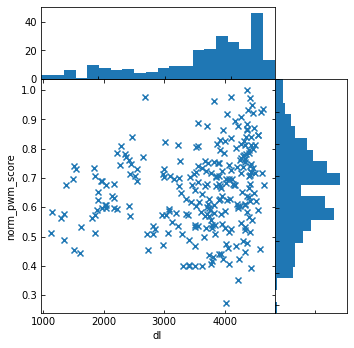

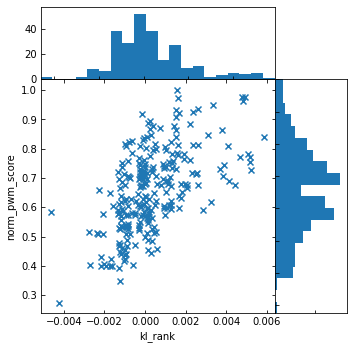

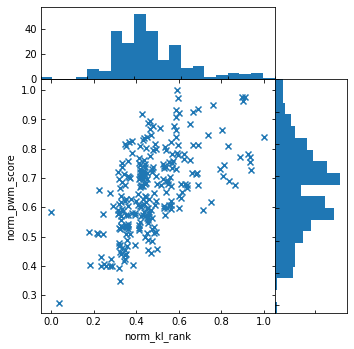

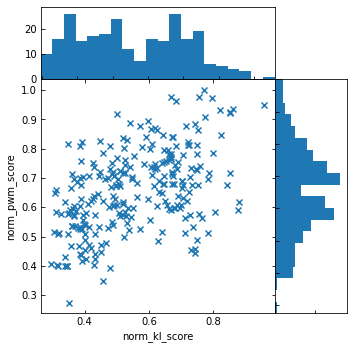

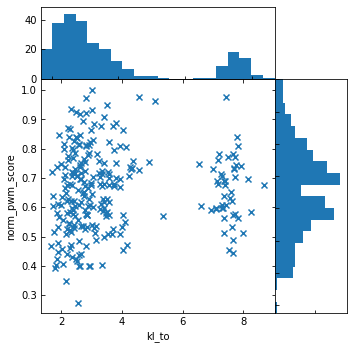

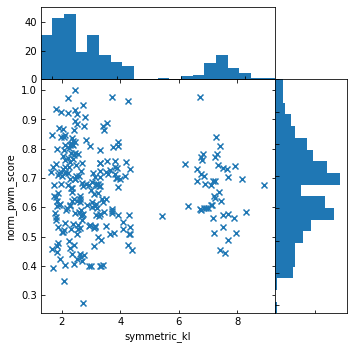

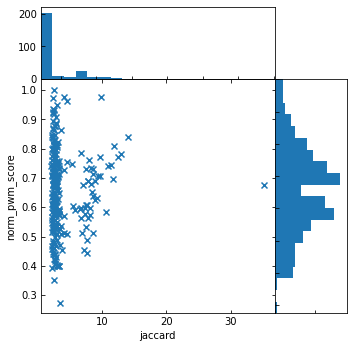

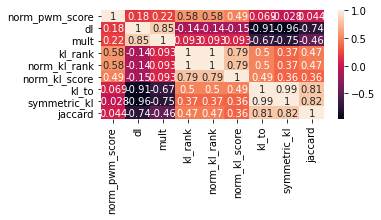

In [127]:
df = exp1_df

plot_2d_scatter(df, 'dl', 'norm_pwm_score')

plot_2d_scatter(df, 'kl_rank', 'norm_pwm_score')
plot_2d_scatter(df, 'norm_kl_rank', 'norm_pwm_score')
plot_2d_scatter(df, 'norm_kl_score', 'norm_pwm_score')
plot_2d_scatter(df, 'kl_to', 'norm_pwm_score')
plot_2d_scatter(df, 'symmetric_kl', 'norm_pwm_score')
plot_2d_scatter(df, 'jaccard', 'norm_pwm_score')

import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
plt.figure(figsize=(5,2))
corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

----

# A simple procedure to extract maximal words given a DL threshold

A simple procedure to extract word as long as possible such that they are present in a certain percentage of sequences is given in what follows.<br>
The aim of the procedure is to extend a given word $w$ ultil the support threshold is satisfied.<br>
Thus, given a threshold $t$, which represent a minimum number of sequences where words must occurr, and a word $w$ such that $dl(w,S)\geq t$,  $w$ is considered maximal if there not exist an elongation of $w$, $wx : x \in \{A,C,G,T\}$, such that $dl(wx,S)\geq t$.<br>
Maximal words are extracted by the algorithm. In contrast, words that satisfy the threshold but that are not maximal, are discarded and their elogations are taken into account.<br>
The procedure is a recursive algoritm which starts form 1-mers and elongate them until maximal words are reached. If 1-mers are considered as roots of a prefix tree, it can be shown that this bottom-up procedure extracts the same words of a top-down procedure which, in constrats, works by aggregating *unfrequent* words.


In [11]:
def get_intervals(istart, iend, k, dnesa):
    """
    Given a word length k, a DNESA, and an initial lcp-interval with coordinates istar-iend which represent a k-mer w, 
    the procedures searches the lcp-interval of the 4 elongations wA, wC, wG and wT.
    The procedure is inefficient since it can be done by a dicotomic seach rather than a linear scan.
    """
    intervals = list()
    
    rstart = istart
    while (rstart < iend) and (dnesa.nn[rstart] <= k) :
        rstart += 1
    
    while rstart < iend:
        rend = rstart + 1
        c = dnesa.gs[ dnesa.sa[rstart] +k ]
        while (rend < iend) and (dnesa.nn[ rend ] >=k ) and ( dnesa.gs[ dnesa.sa[rend] +k ] == c ):
            rend += 1
        intervals.append( (c, rstart, rend) )
        rstart = rend
    return intervals


#good_words = list()
def up_until_dl_thr(w, istart, iend, k, cdl, dl_thr, dnesa, good_words):
    """
    A recursive procedure to extend a word w into an extension wX until dl(wX,S) >= dl_thr, the input support threshold.
    Found maximal words are added up to the list good_words
    """
    intervals = get_intervals(istart, iend, k+1, dnesa)
    #print(intervals)

    good_intervals = list()
    for interval in intervals:
        idl = len(set( dnesa.dl[interval[1]: interval[2]] ))
        if idl >= dl_thr:
            good_intervals.append((interval, idl))

    #print(good_intervals)

    if len(good_intervals)>0:
        for interval in good_intervals:
            up_until_dl_thr(  w+interval[0][0], interval[0][1], interval[0][2], k+1, interval[1], dl_thr, dnesa, good_words )
    else:
        #print(w, cdl)
        good_words.append( (w,istart,iend) )



The support threshold is named *dl_thr_perc* and it is defined as a percentage of the input set $S$.

In [12]:
import math

def extract_maximal_dl_words(iseqs, inelsa, dl_thr_perc):
    # we firstly read the input set S and the DNESA data structure
    epeaks, es2n, egs = read_global_sequence(iseqs)
    edf = pandas.read_csv(inelsa)
    print(len(epeaks), len(es2n), len(egs))
    e_dnesa = DNESA(list(edf.sa), list(edf.lcp), list(edf.nn), list(edf.dl), egs)


    total_dl = len(set(e_dnesa.dl))
    print('total peaks',total_dl)

    #dl_thr_perc = 0.6  #<---- this is the threshold parameter
    dl_thr = math.ceil( total_dl*dl_thr_perc )
    print('thr',dl_thr_perc, '=', dl_thr)


    istart = 0
    iend = len(e_dnesa.gs)

    print('getting 0 intervals')
    intervals = get_intervals(istart, iend, 0, e_dnesa)
    print(intervals)

    good_words = list() 
    for interval in intervals:
        print(interval)
        up_until_dl_thr( interval[0], interval[1], interval[2], 0,  len(set(e_dnesa.dl[interval[1]:interval[2]])), dl_thr, e_dnesa, good_words  )
        
    return good_words

In [130]:
good_words = extract_maximal_dl_words(iipeaks, iipeaks_nelsa, 0.8)
print(len(good_words),'extracted words')

5000 5000 2416122
total peaks 5000
thr 0.8 = 4000
getting 0 intervals
[('A', 5000, 605211), ('C', 605211, 1210476), ('G', 1210476, 1817020), ('T', 1817020, 2416122)]
('A', 5000, 605211)
('C', 605211, 1210476)
('G', 1210476, 1817020)
('T', 1817020, 2416122)
116 extracted words


In [131]:
print(sorted([ s[0] for s in good_words]))
print(len(good_words))

['AAAA', 'AAAC', 'AAAG', 'AAAT', 'AACA', 'AAGA', 'AAGC', 'AAGG', 'AATG', 'ACAG', 'ACCA', 'ACCT', 'ACTG', 'AGAA', 'AGAG', 'AGCA', 'AGCC', 'AGCT', 'AGGA', 'AGGC', 'AGGG', 'AGGT', 'AGTG', 'ATA', 'ATC', 'ATG', 'ATTT', 'CAAA', 'CAAG', 'CACA', 'CACC', 'CACT', 'CAGA', 'CAGC', 'CAGG', 'CAGT', 'CAT', 'CCAA', 'CCAC', 'CCAG', 'CCAT', 'CCCA', 'CCCT', 'CCTC', 'CCTG', 'CCTT', 'CG', 'CTA', 'CTCA', 'CTCC', 'CTCT', 'CTGA', 'CTGC', 'CTGG', 'CTGT', 'CTTC', 'CTTG', 'CTTT', 'GAAA', 'GAAG', 'GAC', 'GAGA', 'GAGC', 'GAGG', 'GAT', 'GCAG', 'GCCA', 'GCCC', 'GCCT', 'GCTC', 'GCTG', 'GCTT', 'GGAA', 'GGAG', 'GGCA', 'GGCT', 'GGGA', 'GGGC', 'GGTG', 'GTA', 'GTC', 'GTGA', 'GTGG', 'GTT', 'TAA', 'TAC', 'TAG', 'TAT', 'TCAC', 'TCAG', 'TCCA', 'TCCC', 'TCCT', 'TCTC', 'TCTG', 'TCTT', 'TGAA', 'TGAG', 'TGCA', 'TGCC', 'TGCT', 'TGGA', 'TGGC', 'TGGG', 'TGGT', 'TGTC', 'TGTG', 'TGTT', 'TTA', 'TTCA', 'TTCC', 'TTCT', 'TTGG', 'TTTC', 'TTTG', 'TTTT']
116


---- 

# A comparison on variable-length words, with the sequence re-extraction model

In [15]:
import pandas 
epeaks, es2n, egs = read_global_sequence(iipeaks)
edf = pandas.read_csv(iipeaks_nelsa)
print(len(epeaks), len(es2n), len(egs))
e_dnesa = DNESA(list(edf.sa), list(edf.lcp), list(edf.nn), list(edf.dl), egs)

rpeaks, rs2n, rgs = read_global_sequence(ireextraction)
rdf = pandas.read_csv(ireextraction_nelsa)
print(len(rpeaks), len(rs2n), len(rgs))
r_dnesa = DNESA(list(rdf.sa), list(rdf.lcp), list(rdf.nn), list(rdf.dl), rgs)

r10peaks, r10s2n, r10gs = read_global_sequence(imultiplere)
r10df = pandas.read_csv(imultiplere_nelsa)
print(len(r10peaks), len(r10s2n), len(r10gs))
r10_dnesa = DNESA(list(r10df.sa), list(r10df.lcp), list(r10df.nn), list(r10df.dl), r10gs)

ctcf = read_jaspar(imotif)

5000 5000 2416122
5000 5000 2416122
5000 5000 24166220


We first need to calculate $kl\_rank$ for words in a range of lengths.

In [16]:
d_kl_rank = dict()
d_norm_kl_rank = dict()

for k in range(2,7):
    print(k)
    k_kl_rank, k_norm_kl_rank =  get_kl_scores(k, egs, e_dnesa, rgs, r_dnesa)
    for s in k_kl_rank:
        d_kl_rank[ s[1] ] = s[0]
    for s in k_norm_kl_rank:
        d_norm_kl_rank[ s[1] ] = s[0]


2
3
4
5
6


Now we extract the words by usgin the simple procedure based on DL threshold

In [17]:
dl_thr = 0.8
extracted_words = extract_maximal_dl_words(iipeaks,iipeaks_nelsa, dl_thr)
print(len(extracted_words),'extracted words')

5000 5000 2416122
total peaks 5000
thr 0.8 = 4000
getting 0 intervals
[('A', 5000, 605211), ('C', 605211, 1210476), ('G', 1210476, 1817020), ('T', 1817020, 2416122)]
('A', 5000, 605211)
('C', 605211, 1210476)
('G', 1210476, 1817020)
('T', 1817020, 2416122)
116 extracted words


In [18]:
seq_lengths = dict()
for i in range(len(epeaks)):
    seq_lengths[i] = len(epeaks[i][0])
nof_peaks = len(epeaks)

kl_rank = list()
norm_kl_rank = list()
mult = list()
dl = list()
norm_pwm_score = list()
norm_kl = list()
kl_to = list()
norm_kl10 = list()
symmetric_kl = list()
jaccard = list()

for kmer in extracted_words:
    kmer = kmer[0]
    norm_pwm_score.append( get_normalized_motif_score(ctcf, kmer)[0] )
    
    kl_rank.append( d_kl_rank.get(kmer, 0) )
    norm_kl_rank.append( d_norm_kl_rank.get(kmer, 0) )
    
    norm_kl.append( calculate_norm_kl(kmer, egs, e_dnesa, rgs, r_dnesa, seq_lengths, nof_peaks ) )
    norm_kl10.append( calculate_norm_kl(kmer, egs, e_dnesa, r10gs, r10_dnesa, seq_lengths, nof_peaks ) )
    
    ks, ke = e_dnesa.search(kmer)
    if ks:
        rs, rf = r_dnesa.search(kmer)
        if rs:
            d1 = get_m_distr( e_dnesa, ks, ke )
            d2 = get_m_distr( r_dnesa, rs, rf )
            jaccard.append(calulcate_generalized_jaccard(d1,d2))
            
            d1 = make_prob_distr( add_unzeros( m_dsitr_to_seq_freq( get_m_distr( e_dnesa, ks, ke ), seq_lengths, len(kmer) ), nof_peaks) )
            d2 = make_prob_distr( add_unzeros( m_dsitr_to_seq_freq( get_m_distr( r_dnesa, rs, rf ), seq_lengths, len(kmer) ), nof_peaks) )
            kl_to.append( calculate_kl(d1,d2) )
            symmetric_kl.append( calculate_symmetric_kl(d1,d2) )
        else:
            symmetric_kl.append(0)
            jaccard.append(0)
        
        mult.append(ke-ks)
        dl.append( len(set(edf.dl[ks:ke])))
    else:
        mult.append(0)
        dl.append(0)
        symmetric_kl.append(0)
        jaccard.append(0)
        
import pandas
exp1_df = pandas.DataFrame()
exp1_df['kmer'] = [kmer[0] for kmer in extracted_words]
exp1_df['norm_pwm_score'] = norm_pwm_score
exp1_df['dl'] = dl
exp1_df['mult'] = mult
exp1_df['kl_rank'] = kl_rank
exp1_df['norm_kl_rank'] = norm_kl_rank
exp1_df['norm_kl_score'] = norm_kl
exp1_df['kl_to'] = kl_to
exp1_df['norm_kl10_score'] = norm_kl
exp1_df['symmetric_kl'] = symmetric_kl
exp1_df['jaccard'] = jaccard

print('-'*40)
display(exp1_df)

exp1_df.to_csv('scores.best5000.re-extract.simple-maximal.'+str(dl_thr)+'.csv')

----------------------------------------


,kmer,norm_pwm_score,dl,mult,kl_rank,norm_kl_rank,norm_kl_score,kl_to,norm_kl10_score,symmetric_kl,jaccard
0,AAAA,0.585546,4007,22578,-0.004621,0.000000,0.310706,2.272410,0.310706,2.580521,3.396131
1,AAAC,0.472941,4016,10564,-0.001230,0.323587,0.412984,2.322737,0.412984,2.397369,2.652691
2,AAAG,0.638992,4375,14065,-0.001175,0.328833,0.429816,1.725479,0.429816,1.723452,2.357810
3,AAAT,0.514286,4068,15032,-0.002750,0.178554,0.303408,1.767217,0.303408,2.047032,2.639213
4,AACA,0.695126,4026,10972,-0.001267,0.320067,0.367171,2.093173,0.367171,2.277298,2.632656
...,...,...,...,...,...,...,...,...,...,...,...
111,TTCT,0.391261,4444,15138,-0.001285,0.318351,0.477920,1.780425,0.477920,1.693696,2.313512
112,TTGG,0.677311,4159,10254,-0.000214,0.420557,0.497483,2.336672,0.497483,2.206733,2.428334
113,TTTC,0.531092,4344,14728,-0.001095,0.336497,0.443682,1.878125,0.443682,1.879577,2.421998
114,TTTG,0.422185,4230,12671,-0.001696,0.279107,0.403074,1.858559,0.403074,1.941352,2.492521


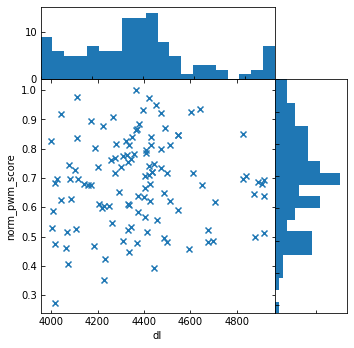

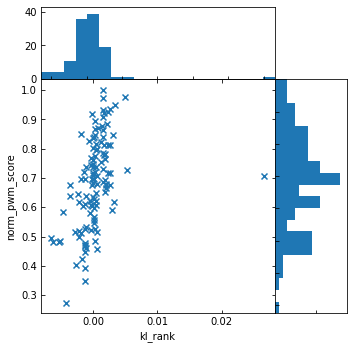

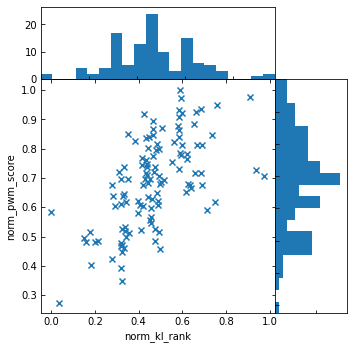

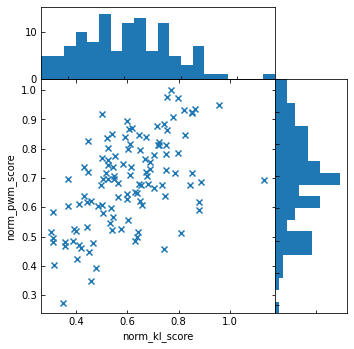

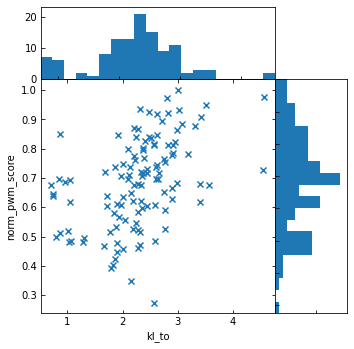

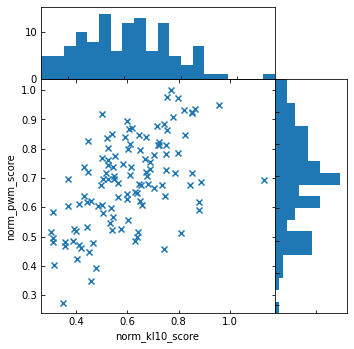

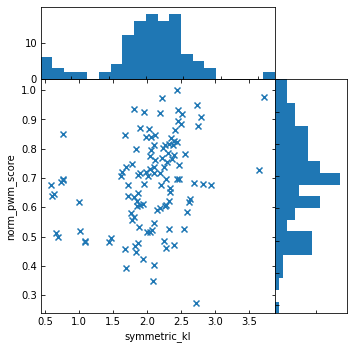

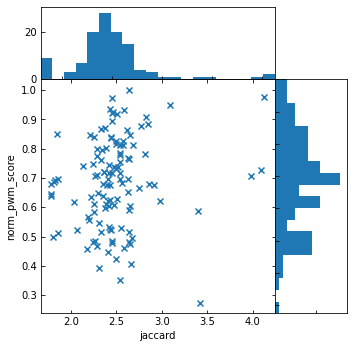

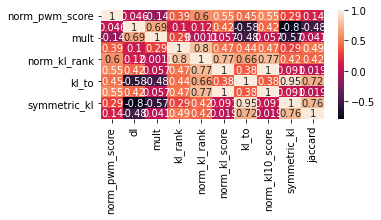

In [19]:
%matplotlib inline
df = exp1_df

plot_2d_scatter(df, 'dl', 'norm_pwm_score')

plot_2d_scatter(df, 'kl_rank', 'norm_pwm_score')
plot_2d_scatter(df, 'norm_kl_rank', 'norm_pwm_score')
plot_2d_scatter(df, 'norm_kl_score', 'norm_pwm_score')
plot_2d_scatter(df, 'kl_to', 'norm_pwm_score')
plot_2d_scatter(df, 'norm_kl10_score', 'norm_pwm_score')
plot_2d_scatter(df, 'symmetric_kl', 'norm_pwm_score')
plot_2d_scatter(df, 'jaccard', 'norm_pwm_score')

import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
plt.figure(figsize=(5,2))
corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

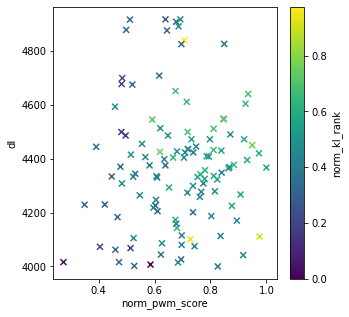

In [20]:
plot_2d_scatter_colors(df, 'norm_pwm_score',  'dl', 'norm_kl_rank', plotsize=(5,5))

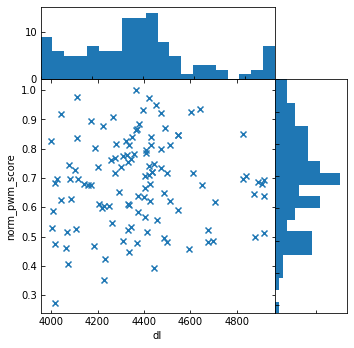

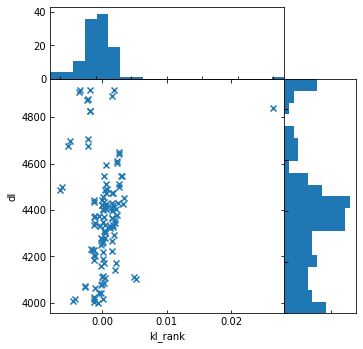

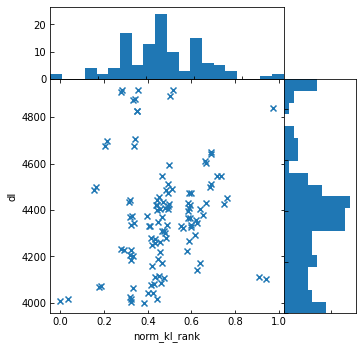

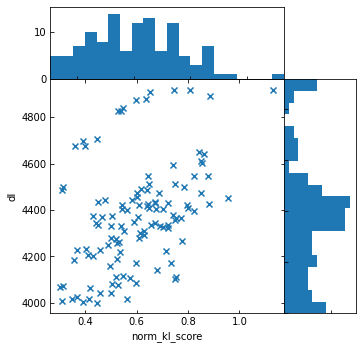

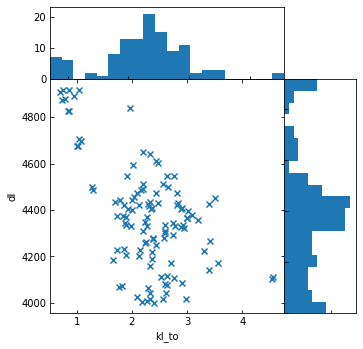

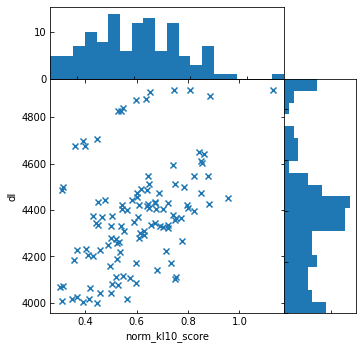

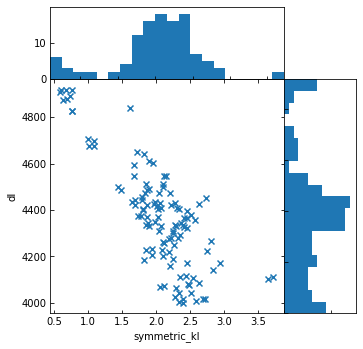

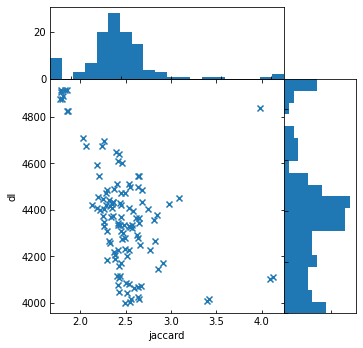

In [21]:
df = exp1_df

plot_2d_scatter(df, 'dl', 'norm_pwm_score')

plot_2d_scatter(df, 'kl_rank', 'dl')
plot_2d_scatter(df, 'norm_kl_rank', 'dl')
plot_2d_scatter(df, 'norm_kl_score', 'dl')
plot_2d_scatter(df, 'kl_to', 'dl')
plot_2d_scatter(df, 'norm_kl10_score', 'dl')
plot_2d_scatter(df, 'symmetric_kl', 'dl')
plot_2d_scatter(df, 'jaccard', 'dl')

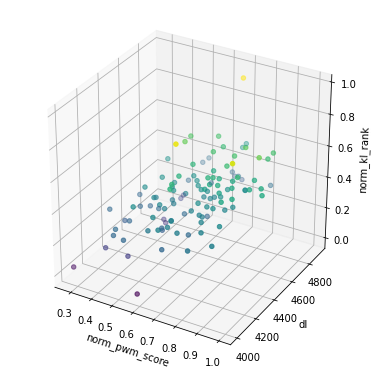

In [142]:
plot_3d_scatter(df, 'norm_pwm_score',  'dl', 'norm_kl_rank', 'norm_kl_rank', plotsize=(5,5))

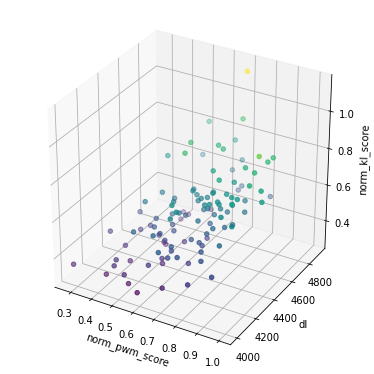

In [143]:
plot_3d_scatter(df, 'norm_pwm_score',  'dl', 'norm_kl_score', 'norm_kl_score' , plotsize=(5,5))

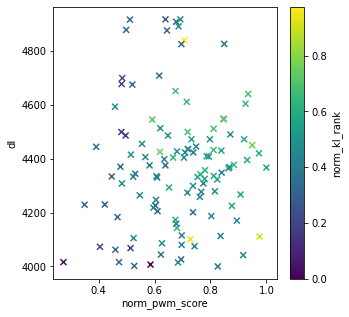

In [144]:
plot_2d_scatter_colors(df, 'norm_pwm_score',  'dl', 'norm_kl_rank', plotsize=(5,5))

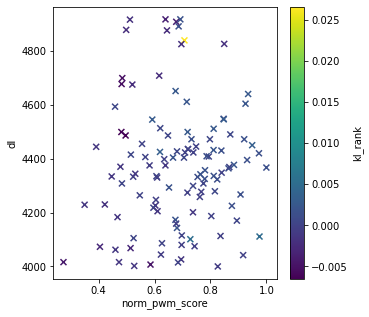

In [145]:
plot_2d_scatter_colors(df, 'norm_pwm_score',  'dl', 'kl_rank', plotsize=(5,5))

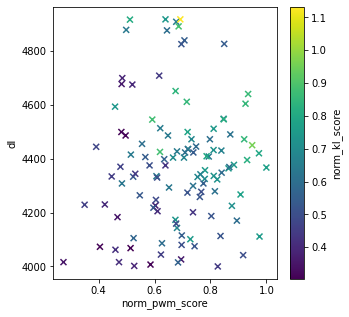

In [146]:
plot_2d_scatter_colors(df, 'norm_pwm_score',  'dl', 'norm_kl_score', plotsize=(5,5))

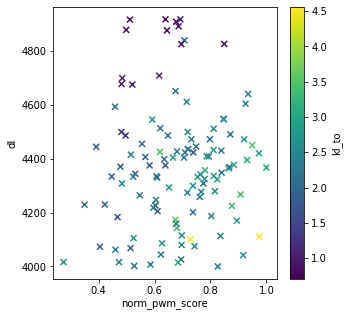

In [148]:
plot_2d_scatter_colors(df, 'norm_pwm_score',  'dl', 'kl_to', plotsize=(5,5))

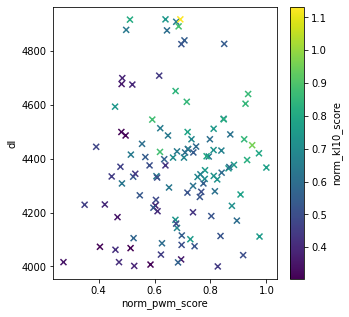

In [216]:
plot_2d_scatter_colors(df, 'norm_pwm_score',  'dl', 'norm_kl10_score', plotsize=(5,5))

----

# An LCP-based word extraction procedure

We evaluated the use of a procedure to extract varibale-length words by their properties on the LCP array.<br>
More in particular we are interested in merging words which are locate next each other in the suffix arry by looking at the value of thier corresponding LCP data<br>
Thus, we aim at extracting a set of *clusters* in the LCP array such that each cluster defines a specific set of suffixxes sharing a common prefix.<br>

A possible usage of the clustering result is to use the common prefix as representative word for the entire LCP cluster.

In [22]:
import numpy as np
import pandas as pd


def find_clusters_ferragina(lcp, min_lcp_val=3):
    """
    Find clusters of sequences by looking at local minima
    on the LCP-array.

    :param esa: (Esa) enhanced suffix array of a set of
                        input sequences
    :param min_lcp_val: (int) minimum threshold on the LCP value
                                to put two consecutive suffixes in
                                a cluster
    :return: cluster starts and ends points defined
    """
    lcp_len = len(lcp)

    clust_starts = []
    clust_lengths = []
    clust_ends = []

    start = None

    for i in range(1, lcp_len):

        if (start != None and
                (lcp[i] < min_lcp_val or
                 (lcp[i] < lcp[i - 1] and lcp[i] < lcp[i + 1]))):
            clust_starts.append(start)
            clust_ends.append(i)
            clust_lengths.append(i - start + 1)

            start = None

        if (start == None and lcp[i] >= min_lcp_val):
            start = i

        elif (start == None and lcp[i] < min_lcp_val):
            continue

    if (start != None):
        clust_starts.append(start)
        clust_ends.append(i)
        clust_lengths.append(i - start + 1)

    assert len(clust_starts) == len(clust_ends)

    return clust_starts, clust_ends

# end of __find_clusters_ferragina()


def merge_clusters(lcp, clusters_starts, clusters_ends):
    """
    Procedure to enlarge clusters computed with the previous method.
    The clusters are merged together using a hierarchical clustering
    like procedure

    :param esa: (Esa) enhanced suffix array with cluster starts
                        and ends points defined
    :return: enhanced suffix array with merged clusters
    """

    max_array = [-1] * len(clusters_starts)
    min_array = [-1] * len(clusters_starts)

    clusters_num = len(clusters_starts)

    for i in range(clusters_num):
        max_array[i] = max(lcp[clusters_starts[i]:(clusters_ends[i] + 1)])
        min_array[i] = lcp[clusters_ends[i]]

    clust_starts_new = []
    clust_ends_new = []
    max_arr_new = []
    min_arr_new = []

    j = 0
    while (j < 100000):  # set an upperbound of iterations (never reached)

        clusters_num = len(clusters_starts)

        for i in range(0, clusters_num - 1, 2): # step by 2
            if (min_array[i] / max_array[i + 1]) > 0.5:
                # merge the two clusters
                clust_starts_new.append(clusters_starts[i])
                clust_ends_new.append(clusters_ends[i + 1])
                max_arr_new.append(max(max_array[i], max_array[i + 1]))
                min_arr_new.append(min_array[i + 1])

            else:
                clust_starts_new.append(clusters_starts[i])
                clust_starts_new.append(clusters_starts[i + 1])
                clust_ends_new.append(clusters_ends[i])
                clust_ends_new.append(clusters_ends[i + 1])
                max_arr_new.append(max_array[i])
                max_arr_new.append(max_array[i + 1])
                min_arr_new.append(min_array[i])
                min_arr_new.append(min_array[i + 1])

        assert (len(clust_starts_new) == len(clust_ends_new))
        assert (len(clust_starts_new) == len(max_arr_new))
        assert (len(clust_starts_new) == len(min_arr_new))

        if not len(clust_starts_new) < clusters_num:  # no clusters have been merged
            break

        else:
            clusters_starts = clust_starts_new
            clusters_ends = clust_ends_new
            max_array = max_arr_new
            min_array = min_arr_new

            # reset for new iteration
            clust_starts_new = []
            clust_ends_new = []
            max_arr_new = []
            min_arr_new = []

            j += 1

    return clust_starts_new, clust_ends_new

In [14]:
import pandas 
epeaks, es2n, egs = read_global_sequence(iipeaks)
edf = pandas.read_csv(iipeaks_nelsa)
print(len(epeaks), len(es2n), len(egs))
e_dnesa = DNESA(list(edf.sa), list(edf.lcp), list(edf.nn), list(edf.dl), egs)

5000 5000 2416122


In [23]:
elcp = [ min( e_dnesa.lcp[i], e_dnesa.nn[i] ) for i in range(len(e_dnesa.lcp))]

ics, ice = find_clusters_ferragina(elcp)
cs, ce = merge_clusters(elcp, ics, ice)

c_size = dict()
for i in range(len(cs)):
    l = ce[i] - cs[i]
    c_size[l] = c_size.get(l, 0) +1

print('number of LCP clusters', len(cs))
print('-'*10)
print('cluster size / number of clusters')
for k,v in sorted(c_size.items()):
    print(k,v)

number of LCP clusters 25350
----------
cluster size / number of clusters
2 86
3 140
4 151
5 205
6 235
7 228
8 203
9 225
10 211
11 230
12 230
13 216
14 237
15 211
16 221
17 201
18 218
19 182
20 211
21 194
22 208
23 194
24 196
25 208
26 213
27 181
28 218
29 200
30 219
31 184
32 188
33 204
34 204
35 189
36 179
37 186
38 195
39 151
40 188
41 190
42 173
43 182
44 186
45 152
46 171
47 156
48 173
49 174
50 184
51 194
52 178
53 177
54 185
55 141
56 139
57 169
58 165
59 146
60 157
61 141
62 147
63 162
64 168
65 150
66 164
67 138
68 135
69 129
70 159
71 137
72 148
73 146
74 141
75 147
76 131
77 136
78 129
79 118
80 116
81 141
82 127
83 124
84 113
85 124
86 121
87 102
88 125
89 125
90 113
91 106
92 145
93 119
94 119
95 113
96 113
97 105
98 96
99 96
100 92
101 99
102 94
103 100
104 91
105 93
106 82
107 92
108 103
109 75
110 103
111 97
112 111
113 92
114 99
115 88
116 86
117 99
118 107
119 90
120 71
121 87
122 75
123 71
124 80
125 69
126 83
127 70
128 68
129 88
130 77
131 68
132 92
133 79
134 67
1

In [24]:
word_lengths = dict()
lcp_extracted_words = list()
ss = set()
for i in range(len(cs)):
    if ce[i]-cs[i] > 3:
        min_lcp = min(e_dnesa.lcp[ cs[i]+1 : ce[i]-1 ])
        word_lengths[min_lcp] = word_lengths.get(min_lcp, 0)+1
        word = egs[ e_dnesa.sa[ cs[i] ] :  e_dnesa.sa[ cs[i] ] + min_lcp ]
        lcp_extracted_words.append(word)
        if word == 'CCA':
            print(word, ce[i]-cs[i], len(set(e_dnesa.dl[cs[i] : ce[i]]))  )
        if i>10000 and i < 10050:
            print(word, ce[i]-cs[i], len(set(e_dnesa.dl[cs[i] : ce[i]]))  )
        if len(word)==3:
            ss.add(word[:3])
        if len(word)==10 and i>12000 and i < 12200:
            print('@',word, ce[i]-cs[i], len(set(e_dnesa.dl[cs[i] : ce[i]]))  )
        if len(word)==7 and i>8000 and i < 8200:
            print('#',word, ce[i]-cs[i], len(set(e_dnesa.dl[cs[i] : ce[i]]))  )

print('-'*20)
print(sorted(ss))
print('-'*20)
print(len(lcp_extracted_words))
print('-'*10)
print('word length / number of words')
for k,v in sorted(word_lengths.items()):
    print(k,v)
    
print(lcp_extracted_words[:100])

# CATGTTT 122 118
# CATTAAA 105 103
# CATTAAC 113 111
# CATTAAG 118 116
# CATTAAT 35 35
# CATTAAT 87 85
# CATTACT 105 102
# CATTAGC 97 96
# CATTAGG 73 73
# CATTATC 63 63
# CATTCAC 102 97
# CATTCAT 86 81
# CATTCCA 201 197
# CATTCCC 199 196
# CATTCCG 44 44
# CATTCCT 99 99
# CATTCCT 80 77
# CATTCTT 256 241
# CATTGAT 52 51
# CATTGCA 64 64
# CATTGCT 24 24
# CATTGCT 165 162
# CATTGGT 83 81
# CATTTAA 189 185
# CATTTAC 35 31
# CATTTAG 22 22
# CATTTAG 84 83
# CATTTAT 129 124
# CATTTAT 104 101
# CATTTCA 132 130
# CATTTCA 123 121
# CATTTCC 229 220
# CATTTCG 31 31
# CATTTCT 83 80
# CATTTCT 163 161
# CATTTCT 150 146
# CATTTGA 61 61
# CATTTGC 190 181
# CATTTGG 193 187
# CATTTGT 49 48
# CATTTGT 152 148
# CATTTTA 215 212
# CATTTTC 274 260
# CATTTTG 78 77
# CATTTTG 247 237
# CATTTTT 225 220
CCA 276 266
# CCAAAAA 60 59
# CCAAAAC 81 79
# CCAAAAC 90 89
# CCAAAAG 172 168
# CCAAAAT 75 74
# CCAAAAT 75 74
# CCAAACA 192 184
# CCAAACC 186 178
# CCAAACG 48 47
# CCAAACT 41 41
# CCAAACT 143 140
# CCAAAGA 141 140
#

In [25]:
discarded = set()
extracted_words = set()
for w in lcp_extracted_words:
    if '$' not in w:
        extracted_words.add(w)
    else:
        discarded.add(w)

print('discarded words because of $')
print(discarded)
print('unredundant extracted words')
extracted_words = sorted(extracted_words)
print(len(extracted_words))

discarded words because of $
set()
unredundant extracted words
19343


In [26]:
rpeaks, rs2n, rgs = read_global_sequence(ireextraction)
rdf = pandas.read_csv(ireextraction_nelsa)
print(len(rpeaks), len(rs2n), len(rgs))
r_dnesa = DNESA(list(rdf.sa), list(rdf.lcp), list(rdf.nn), list(rdf.dl), rgs)

ctcf = read_jaspar(imotif)

5000 5000 2416122


In [27]:
d_kl_rank = dict()
d_norm_kl_rank = dict()

for k in range(2,10):
    print(k)
    k_kl_rank, k_norm_kl_rank =  get_kl_scores(k, egs, e_dnesa, rgs, r_dnesa)
    for s in k_kl_rank:
        d_kl_rank[ s[1] ] = s[0]
    for s in k_norm_kl_rank:
        d_norm_kl_rank[ s[1] ] = s[0]

2
3
4
5
6
7
8
9


In [28]:
seq_lengths = dict()
for i in range(len(epeaks)):
    seq_lengths[i] = len(epeaks[i][0])
nof_peaks = len(epeaks)

kl_rank = list()
norm_kl_rank = list()
mult = list()
dl = list()
norm_pwm_score = list()
norm_kl = list()
kl_to = list()
symmetric_kl = list()
jaccard = list()

for kmer in extracted_words:
    
    #print(kmer, len(kmer), len(ctcf))
    
    if len(kmer) <= len(ctcf['A']):
        norm_pwm_score.append( get_normalized_motif_score(ctcf, kmer)[0] )
    else:
        norm_pwm_score.append( 1.1)
    
    kl_rank.append( d_kl_rank.get(kmer, 0) )
    norm_kl_rank.append( d_norm_kl_rank.get(kmer, 0) )
    
    norm_kl.append( calculate_norm_kl(kmer, egs, e_dnesa, rgs, r_dnesa, seq_lengths, nof_peaks ) )
    
    ks, ke = e_dnesa.search(kmer)
    if ks:
        rs, rf = r_dnesa.search(kmer)
        if rs:
            d1 = get_m_distr( e_dnesa, ks, ke )
            d2 = get_m_distr( r_dnesa, rs, rf )
            jaccard.append(calulcate_generalized_jaccard(d1,d2))
            
            d1 = make_prob_distr( add_unzeros( m_dsitr_to_seq_freq( get_m_distr( e_dnesa, ks, ke ), seq_lengths, len(kmer) ), nof_peaks) )
            d2 = make_prob_distr( add_unzeros( m_dsitr_to_seq_freq( get_m_distr( r_dnesa, rs, rf ), seq_lengths, len(kmer) ), nof_peaks) )
            kl_to.append( calculate_kl(d1,d2) )
            symmetric_kl.append( calculate_symmetric_kl(d1,d2) )
        else:
            symmetric_kl.append(0)
            jaccard.append(0)
            kl_to.append(0)
        
        mult.append(ke-ks)
        dl.append( len(set(edf.dl[ks:ke])))
    else:
        mult.append(0)
        dl.append(0)
        symmetric_kl.append(0)
        jaccard.append(0)
        kl_to.append(0)
        
import pandas
exp1_df = pandas.DataFrame()
exp1_df['kmer'] = [kmer for kmer in extracted_words]
exp1_df['norm_pwm_score'] = norm_pwm_score
exp1_df['dl'] = dl
exp1_df['mult'] = mult
exp1_df['kl_rank'] = kl_rank
exp1_df['norm_kl_rank'] = norm_kl_rank
exp1_df['norm_kl_score'] = norm_kl
exp1_df['kl_to'] = kl_to
exp1_df['symmetric_kl'] = symmetric_kl
exp1_df['jaccard'] = jaccard

print('-'*40)
display(exp1_df)

exp1_df.to_csv('scores.best5000.re-extract.lcp-hierarchical-clustering.csv')

----------------------------------------


,kmer,norm_pwm_score,dl,mult,kl_rank,norm_kl_rank,norm_kl_score,kl_to,symmetric_kl,jaccard
0,AAA,0.485901,4839,62361,-0.009965,0.0,0.463258,1.022022,0.951125,2.306503
1,AAAAAAAA,0.393437,381,1942,-0.000600,0.0,0.933945,11.125114,10.852037,36.132075
2,AAAAAAAAA,0.383581,279,1517,-0.000450,0.0,0.965045,11.514654,11.140206,45.514851
3,AAAAAAAAAA,0.363943,214,1215,0.000000,0.0,0.984655,11.746287,11.328710,52.291667
4,AAAAAAAAAAA,0.339243,171,986,0.000000,0.0,0.995971,11.860516,11.389657,55.767857
...,...,...,...,...,...,...,...,...,...,...
19338,TTTTTTTTTG,0.303988,108,110,0.000000,0.0,1.049567,10.545493,9.855054,118.666667
19339,TTTTTTTTTGT,0.275294,24,24,0.000000,0.0,1.037107,10.328170,9.763411,74.000000
19340,TTTTTTTTTT,0.177619,218,1252,0.000000,0.0,1.011698,12.306042,11.836692,205.588235
19341,TTTTTTTTTTG,0.235406,89,90,0.000000,0.0,1.057297,10.595343,9.855456,149.000000


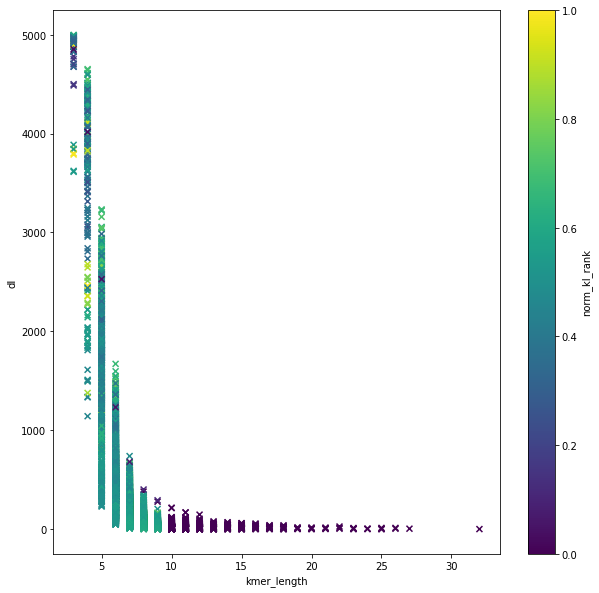

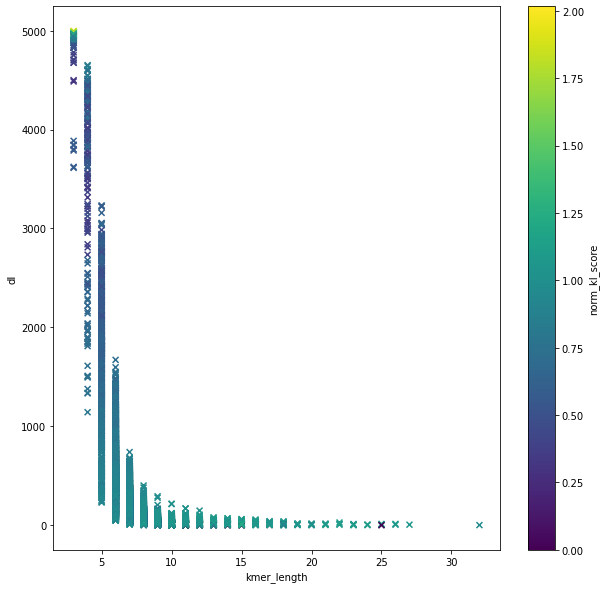

In [29]:
df = exp1_df

df['kmer_length'] = [len(v) for v in df.kmer]
plot_2d_scatter_colors(df, 'kmer_length',  'dl', 'norm_kl_rank', plotsize=(10,10))
plot_2d_scatter_colors(df, 'kmer_length',  'dl', 'norm_kl_score', plotsize=(10,10))

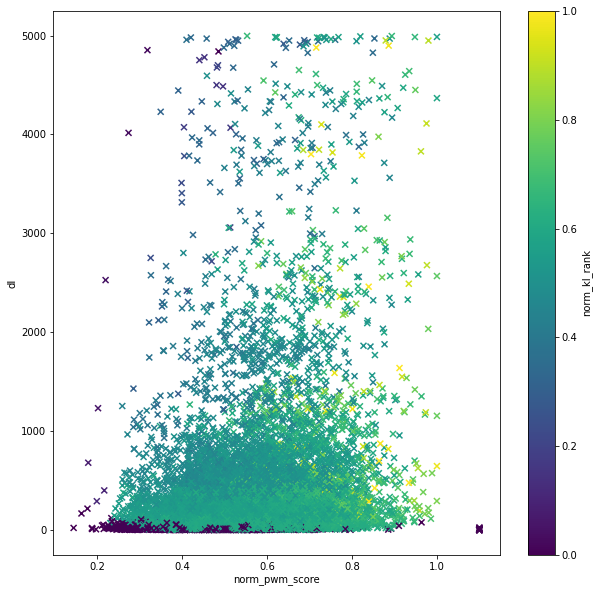

In [30]:
plot_2d_scatter_colors(df, 'norm_pwm_score',  'dl', 'norm_kl_rank', plotsize=(10,10))

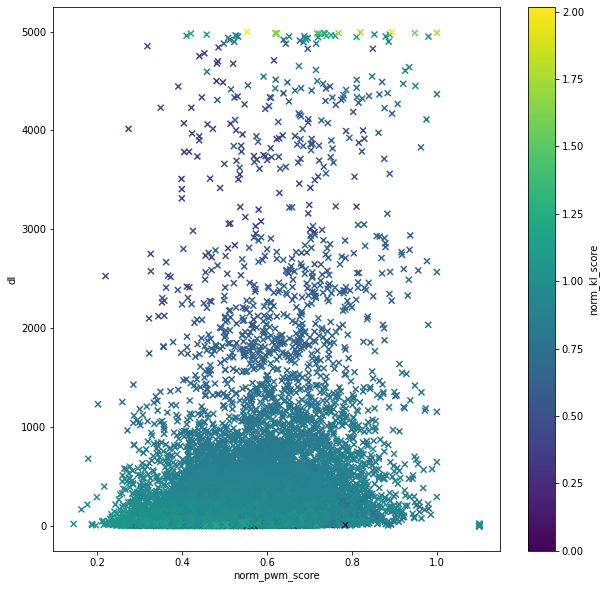

In [31]:
plot_2d_scatter_colors(df, 'norm_pwm_score',  'dl', 'norm_kl_score', plotsize=(10,10))

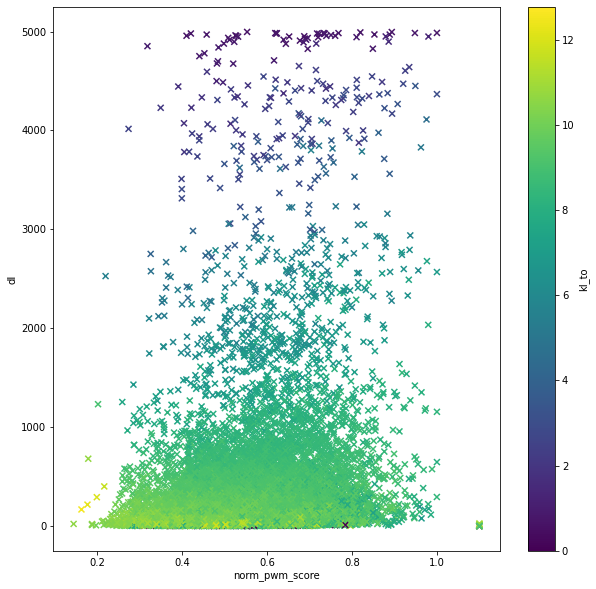

In [32]:
plot_2d_scatter_colors(df, 'norm_pwm_score',  'dl', 'kl_to', plotsize=(10,10))

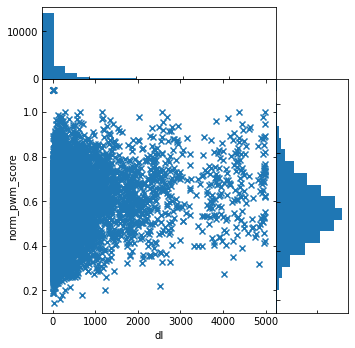

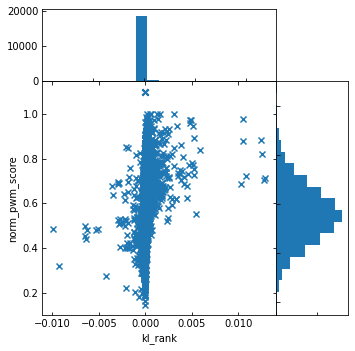

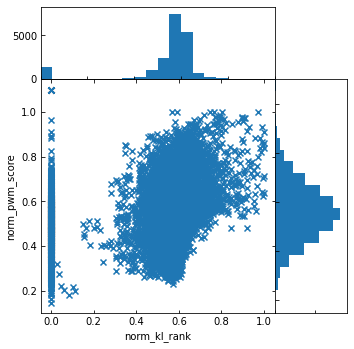

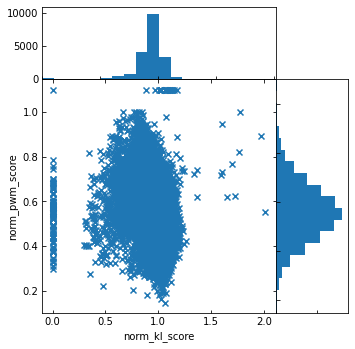

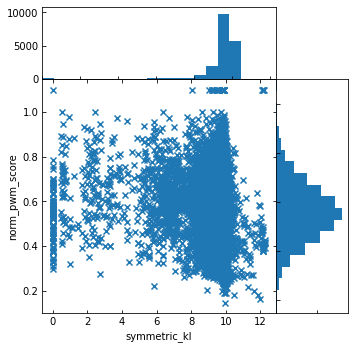

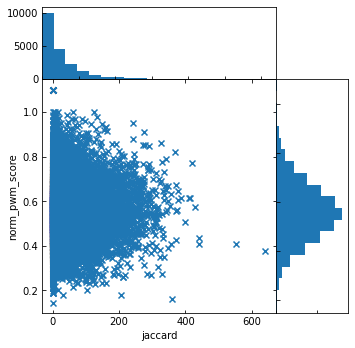

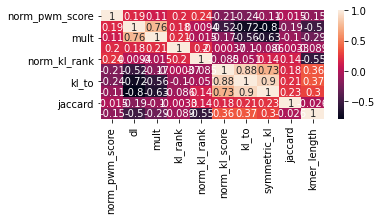

In [33]:
%matplotlib inline
df = exp1_df

plot_2d_scatter(df, 'dl', 'norm_pwm_score')

plot_2d_scatter(df, 'kl_rank', 'norm_pwm_score')
plot_2d_scatter(df, 'norm_kl_rank', 'norm_pwm_score')
plot_2d_scatter(df, 'norm_kl_score', 'norm_pwm_score')
plot_2d_scatter(df, 'symmetric_kl', 'norm_pwm_score')
plot_2d_scatter(df, 'jaccard', 'norm_pwm_score')

import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
plt.figure(figsize=(5,2))
corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

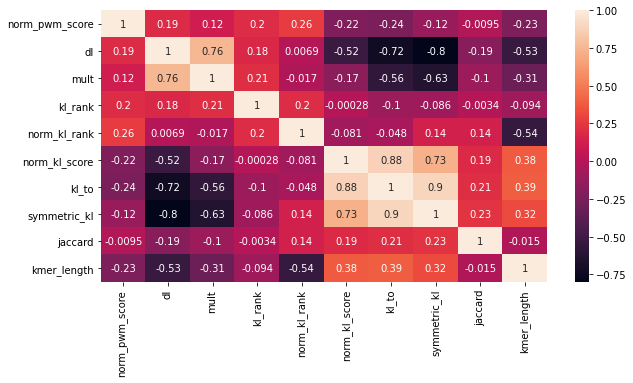

In [37]:

import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
corrMatrix = df[df.norm_pwm_score <= 1.0].corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

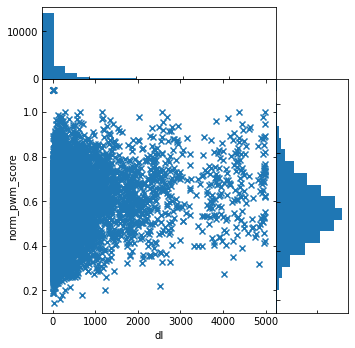

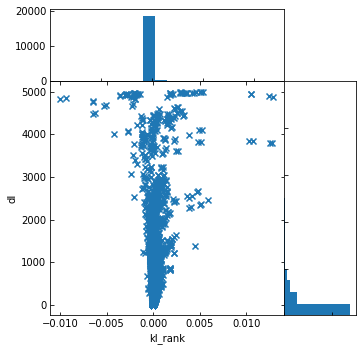

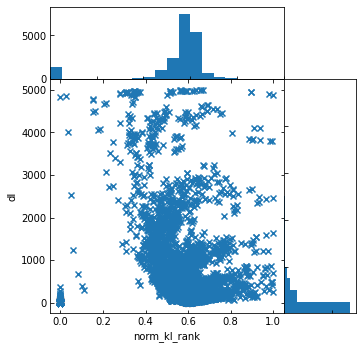

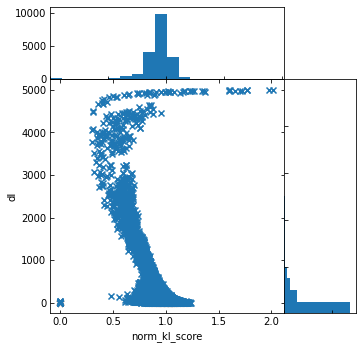

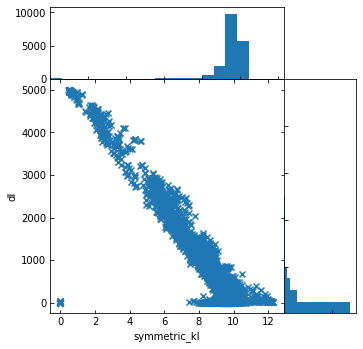

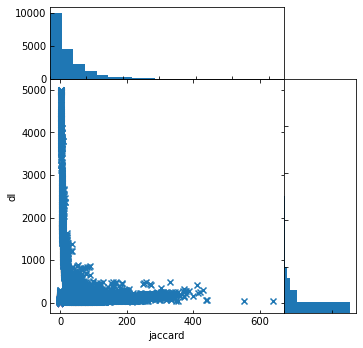

In [40]:
%matplotlib inline
df = exp1_df

plot_2d_scatter(df, 'dl', 'norm_pwm_score')

plot_2d_scatter(df, 'kl_rank', 'dl')
plot_2d_scatter(df, 'norm_kl_rank', 'dl')
plot_2d_scatter(df, 'norm_kl_score', 'dl')
plot_2d_scatter(df, 'symmetric_kl', 'dl')
plot_2d_scatter(df, 'jaccard', 'dl')


In [109]:
wlist = sorted(extracted_words)[:100]
short_words = list()

#for w in wlist:
#    print(w)

def lcp_2by2(a,b):
    if len(a) > len(b):
        return 0
    for l in range(len(a)):
        if a[l] != b[l]:
            return l
    return l+1

print(lcp_2by2('AAA','AAAA'))

#for i in range(len(wlist)):
i = 0
while True:
    if i >= len(wlist):
        break
    if i <len(wlist)-1:
        j = i +1
        print(i, wlist[i], wlist[i+1], lcp_2by2(wlist[j-1], wlist[j]), len(wlist[i]), len(wlist[i+1]))
        while (j<len(wlist)) and (lcp_2by2(wlist[j-1], wlist[j]) == len(wlist[j-1])):
            j += 1
        print(j)
        short_words.append(wlist[i])
        i = j
    else:
        short_words.append(wlist[i])
        i += 1

print( sorted(set(short_words)))
        

3
0 AAA AAAA 3 3 4
10
10 AAAAAAAAAGAA AAAAAAAAGA 0 12 10
11
11 AAAAAAAAGA AAAAAAAAGAAAA 10 10 13
13
13 AAAAAAAG AAAAAAAGA 8 8 9
16
16 AAAAAAC AAAAAAG 6 7 7
17
17 AAAAAAG AAAAAAGA 7 7 8
21
21 AAAAAAGC AAAAAAGTT 7 8 9
22
22 AAAAAAGTT AAAAAAT 0 9 7
23
23 AAAAAAT AAAAAATA 7 7 8
26
26 AAAAAATT AAAAAATTAG 8 8 10
28
28 AAAAAC AAAAACA 6 6 7
33
33 AAAAACAC AAAAACC 0 8 7
34
34 AAAAACC AAAAACCA 7 7 8
36
36 AAAAACTT AAAAACTTA 8 8 9
38
38 AAAAAG AAAAAGA 6 6 7
42
42 AAAAAGAG AAAAAGATT 7 8 9
43
43 AAAAAGATT AAAAAGC 0 9 7
44
44 AAAAAGC AAAAAGCA 7 7 8
46
46 AAAAAGG AAAAAGT 6 7 7
47
47 AAAAAGT AAAAAGTT 7 7 8
49
49 AAAAAT AAAAATA 6 6 7
53
53 AAAAATG AAAAATGT 7 7 8
55
55 AAAAATT AAAAATTAGC 7 7 10
58
58 AAAAATTG AAAAATTTT 7 8 9
59
59 AAAAATTTT AAAAC 0 9 5
60
60 AAAAC AAAACA 5 5 6
67
67 AAAACAAAC AAAACAACT 7 9 9
68
68 AAAACAACT AAAACAAG 0 9 8
69
69 AAAACAAG AAAACAATT 7 8 9
70
70 AAAACAATT AAAACAC 0 9 7
71
71 AAAACAC AAAACACT 7 7 8
73
73 AAAACAG AAAACAGC 7 7 8
75
75 AAAACAGT AAAACAT 0 8 7
76
76 AAAACAT AAAAC

https://hocomoco11.autosome.ru/

http://homer.ucsd.edu/homer/motif/